# Madness at Home and on the Court - Part 1

*Authors: [Emilien Etchevers](https://www.kaggle.com/emimis), [Kieran Janin](https://www.kaggle.com/kieranjanin), [Michael Karpe](https://www.kaggle.com/mika30), [Remi Le Thai](https://www.kaggle.com/remilethai), [Haley Wohlever](https://www.kaggle.com/haleywohlever)*

# Contents

*In this notebook*

- [Introduction](#Introduction) <br>
- [NCAA March Madness Data Analysis](#NCAAMarchMadnessData)<br>
  * [Seeding and Entertainment](#SeedingandEntertainment)<br>
  * [Madness through Unpredictability](#MadnessthroughUnpredictability)<br>
  * [Entertainment due to Closeness of Games](#EntertainmentduetoClosenessofGames)
  
    
*In the* [*second notebook*](https://www.kaggle.com/mika30/madness-at-home-and-on-the-court-part-2): 

- [Tweets on NCAA Data Analysis](#TweetsonNCAAData)<br>
  * [Temporal Evolution of Engagement](#TemporalEvolutionofEngagement)<br>
  * [Team Mentions Count in Tweets](#TeamMentionsCountinTweets)<br>
  * [Sentiment Analysis for Tweets on NCAA](#SentimentAnalysisforTweetsonNCAA)
- [Conclusion](#Conclusion)


# 1. Introduction

March Madness is a period of excitement for everyone: from the die-hard fan to the serial gambler, this NCAA tournament has something for all. One of the major draws of the competition is its intangible and intoxicating element of unpredictability: with the closely packed games and high end teams, there’s always a chance for an upset, for an unexpected streak, or for a “Cinderella story.” We set out here to try to uncover whether or not these seemingly unpredictable moments could be anticipated? What truly contributes to the “madness” of a game and to this season of collegiate basketball?

Our first challenge in this endeavor was attempting to define “madness.” Are we referring to the intensity of the game? the moves of each player on the court? Or are we referring to the crowd’s reaction to the outcome of a match? to the fan’s entertainment back home? Rather than limit our exploration, we decided to consider both possibilities. To do this effectively, we separated our work into two distinct categories: 1) that of empirical and “objective” madness that arises from the teams’ past game statistics and match events, and 2) that of emotional and “subjective” madness that comes from the enthusiasm of the fans while watching a game. This second type of madness is evaluated in a separate notebook which follows this one. Depending on who you ask, madness can have many meanings, but here we focus on it as the entertainment and pleasure that unites everyone around a great game of basketball.


# 2. NCAA March Madness Data Analysis

For exploring the objective madness in this competition, the main data source at our disposal is the NCAA data provided through Kaggle. This data source is full of detailed and relevant information for the 2015 to 2019 seasons, from team and player names down to precisely recorded details on events that occur during each match!

## 2.1. Seeding and Entertainment

The main question we explored is: can entertainment be linked to a team’s seed? In the extreme case of this is whether, by default, watching a seed 1 team compete will inherently be more enjoyable than watching a seed 16 team compete? We did this by first looking at specific events that occur during matches and working to see whether certain events were correlated with certain seeds.

To perform this analysis, we start by loading useful packages as well as the relevant data. We opted to use some pre-processing performed by [JasonVizkovic](https://www.kaggle.com/jaseziv83) in his Notebook: [Moreyball in the College Game...A Full NCAA EDA.](https://www.kaggle.com/jaseziv83/moreyball-in-the-college-game-a-full-ncaa-eda) It was particularly useful for helping us to isolate definite scoring attempts, understand whether they were assisted or not, and more.

In [1]:
library(tidyverse)
library(scales)
library(grid)
library(gridExtra)
library(knitr)
library(ggExtra)
library(zoo) ## curve AUC
options(warn=-1)
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

tourney_seeds <- read.csv("../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneySeeds.csv", stringsAsFactors = FALSE)
#~~~~~~~~~~~~~~~~~~~~~~~
# Read in data
#~~~~~~~~~~~~~~~~~~~~~~~
play_by_play <- data.frame()

# loop through each seasons PlayByPlay folders and read in in the play by play files
for(each in list.files('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data')[str_detect(list.files('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/'), "MEvents")]) {
  df <- read_csv(paste0('../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/', each))
  
  
  # Grouped shooting variables ----------------------------------------------
  # there are some shooting variables that can probably be condensed - tip ins and dunks
  paint_attempts_made <- c("made2_dunk", "made2_lay", "made2_tip") 
  paint_attempts_missed <- c("miss2_dunk", "miss2_lay", "miss2_tip") 
  paint_attempts <- c(paint_attempts_made, paint_attempts_missed)
  # create variables for field goals made, and also field goals attempted (which includes the sum of FGs made and FGs missed)
  FGM <- c("made2_dunk", "made2_jump", "made2_lay",  "made2_tip",  "made3_jump")
  FGA <- c(FGM, "miss2_dunk", "miss2_jump" ,"miss2_lay",  "miss2_tip",  "miss3_jump")
  # variable for three-pointers
  ThreePointer <- c("made3_jump", "miss3_jump")
  #  Two point jumper
  TwoPointJump <- c("miss2_jump", "made2_jump")
  # Free Throws
  FT <- c("miss1_free", "made1_free")
  # all shots
  AllShots <- c(FGA, FT)
  
  
  # Feature Engineering -----------------------------------------------------
  # paste the two even variables together for FGs as this is the format for last years comp data
  df <- df %>%
    mutate_if(is.factor, as.character) %>% 
    mutate(EventType = ifelse(str_detect(EventType, "miss") | str_detect(EventType, "made") | str_detect(EventType, "reb"), paste0(EventType, "_", EventSubType), EventType))
  
  # change the unknown for 3s to "jump" and for FTs "free"
  df <- df %>% 
    mutate(EventType = ifelse(str_detect(EventType, "3"), str_replace(EventType, "_unk", "_jump"), EventType),
           EventType = ifelse(str_detect(EventType, "1"), str_replace(EventType, "_unk", "_free"), EventType))
  
  
  df <- df %>% 
    # create a variable in the df for whether the attempts was made or missed
    mutate(shot_outcome = ifelse(grepl("made", EventType), "Made", ifelse(grepl("miss", EventType), "Missed", NA))) %>%
    # identify if the action was a field goal, then group it into the attempt types set earlier
    mutate(FGVariable = ifelse(EventType %in% FGA, "Yes", "No"),
           AttemptType = ifelse(EventType %in% paint_attempts, "PaintPoints", 
                                ifelse(EventType %in% ThreePointer, "ThreePointJumper", 
                                       ifelse(EventType %in% TwoPointJump, "TwoPointJumper", 
                                              ifelse(EventType %in% FT, "FreeThrow", "NoAttempt")))))
  
  
  # Rework DF so only shots are included and whatever lead to the shot --------
  df <- df %>% 
    mutate(GameID = paste(Season, DayNum, WTeamID, LTeamID, sep = "_")) %>% 
    group_by(GameID, ElapsedSeconds) %>% 
    mutate(EventType2 = lead(EventType),
           EventPlayerID2 = lead(EventPlayerID)) %>% ungroup()
  
  
  df <- df %>% 
    mutate(FGVariableAny = ifelse(EventType %in% FGA | EventType2 %in% FGA, "Yes", "No")) %>% 
    filter(FGVariableAny == "Yes") 
  
  
  # create a variable for if the shot was made, but then the second event was also a made shot
  df <- df %>% 
    mutate(Alert = ifelse(EventType %in% FGM & EventType2 %in% FGM, "Alert", "OK")) %>% 
    # only keep "OK" observations
    filter(Alert == "OK") 
  # replace NAs with somerhing
  df$EventType2[is.na(df$EventType2)] <- "no_second_event"
  
  
  # create a variable for if there was an assist on the FGM:
  df <- df %>% 
    mutate(AssistedFGM = ifelse(EventType %in% FGM & EventType2 == "assist", "Assisted", 
                                ifelse(EventType %in% FGM & EventType2 != "assist", "Solo", 
                                       ifelse(EventType %in% FGM & EventType2 == "no_second_event", "Solo", "None"))))
  
  # # because the FGA culd be either in `EventType` (more likely) or `EventType2` (less likely), need
  # # one variable to indicate the shot type
  
  # create final output
  df <- df %>% ungroup()
  play_by_play <- bind_rows(play_by_play, df)
  
  rm(df);gc()
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.0          ✔ dplyr   0.8.5     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Parsed with column specification:
cols(
  EventID = col_double(),
  Season = col_double(),
  DayNum = col_double(),
  WTeamID = col_double(),
  LTeamID = col_double(),
  WFinalScore = col_

Now, as our goal is to analyze different game events using seeds as an input, it is first necessary for us to associate each event to the seed of the team that performed it.

In [2]:
play_by_play$tot_score<-play_by_play$WFinalScore + play_by_play$LFinalScore

Seeded_pbp <- play_by_play %>% 
  select(EventType,TeamID = EventTeamID,shot_outcome,Season, tot_score) %>%
  merge(tourney_seeds, by = c("Season", "TeamID")) 

Seeded_pbp$Region<-str_sub(Seeded_pbp$Seed,1,1)
Seeded_pbp$Seed<-str_sub(Seeded_pbp$Seed,2,str_length(Seeded_pbp$Seed))
Seeded_pbp<-subset(Seeded_pbp,(str_sub(Seeded_pbp$Seed,-1,-1)!="b")&(str_sub(Seeded_pbp$Seed,-1,-1)!="c"))
Seeded_pbp$Seed<-str_sub(Seeded_pbp$Seed,1,2)

RecapShots <- Seeded_pbp %>%
  group_by(Seed,EventType) %>%
  filter (shot_outcome =='Missed' | shot_outcome =='Made') %>%
  count(shot_outcome)

RecapShots$EventType<-as.factor(str_sub(RecapShots$EventType,5,str_length(RecapShots$EventType)))

Once this is done, we can now plot the number of times each event was performed by a given team. This is done in the hope to uncover some interesting trends: do the highest seeded teams rely on 3-pointers, as Moreyball would predict? do lower seeded teams prefer to rely on safer, 2-point shots?

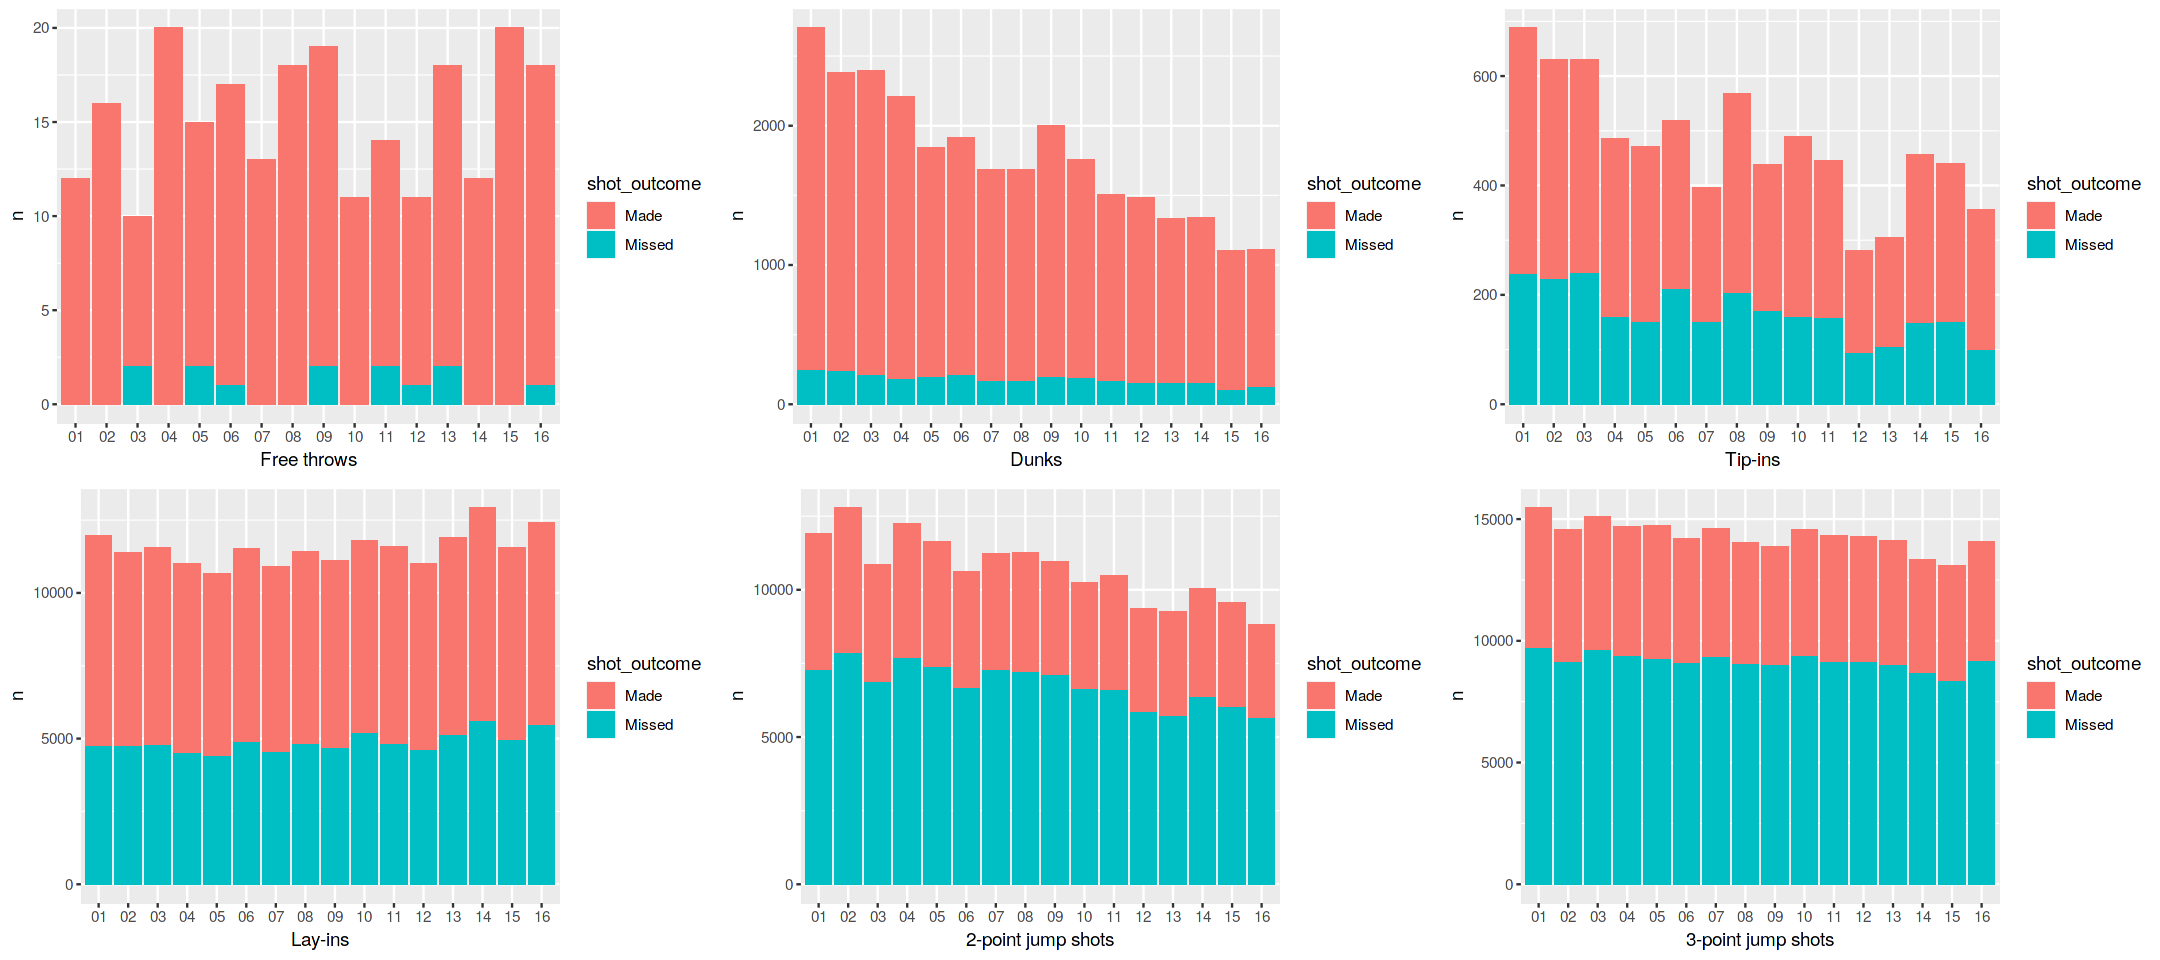

In [3]:
fig(18,8)
pts1<- filter(RecapShots, EventType=="1_free") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("Free throws") 
pts2 <- filter(RecapShots, EventType=="2_dunk") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("Dunks") 
pts3 <- filter(RecapShots, EventType=="2_tip") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("Tip-ins") 
pts4 <- filter(RecapShots, EventType=="2_lay") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("Lay-ins") 
pts5 <- filter(RecapShots, EventType=="2_jump") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("2-point jump shots") 
pts6 <- filter(RecapShots, EventType=="3_jump") %>%
  group_by(EventType) %>%
  ggplot(aes(x=Seed,y=n, fill = shot_outcome)) + geom_bar(stat='identity')  + xlab("3-point jump shots") 

grid.arrange(pts1,pts2,pts3,pts4,pts5,pts6,nrow=2,ncol=3)

Looking at these results, there appears to be no significant difference in the actions performed by each seed except for two: dunks and tip-ins. This finding is particularly interesting because these types of actions are also seen to be the most point-efficient shots in the game! Looking at the average points per attempt, a dunk and a tip-in bring respectively about 1.8 and 1.3 points per attempt (see chart below, credits again to JasonVizkovic).

One may therefore think that a characterization of a good team is its willingness to attempt dunks as often as possible. It must be noted, however, that this type of action requires careful team strategy as it is much harder to set up than a 3-point attempt. It would then seem that maybe it is not a team dunking often that makes it good, but that a good team is able to dunk often. The question of a team's priorities during game play then arises. We can assume that, as the ultimate goal of a team is to win, they prioritize using the most efficient actions possible to score points and do not take into consideration the potential entertainment value of those actions.

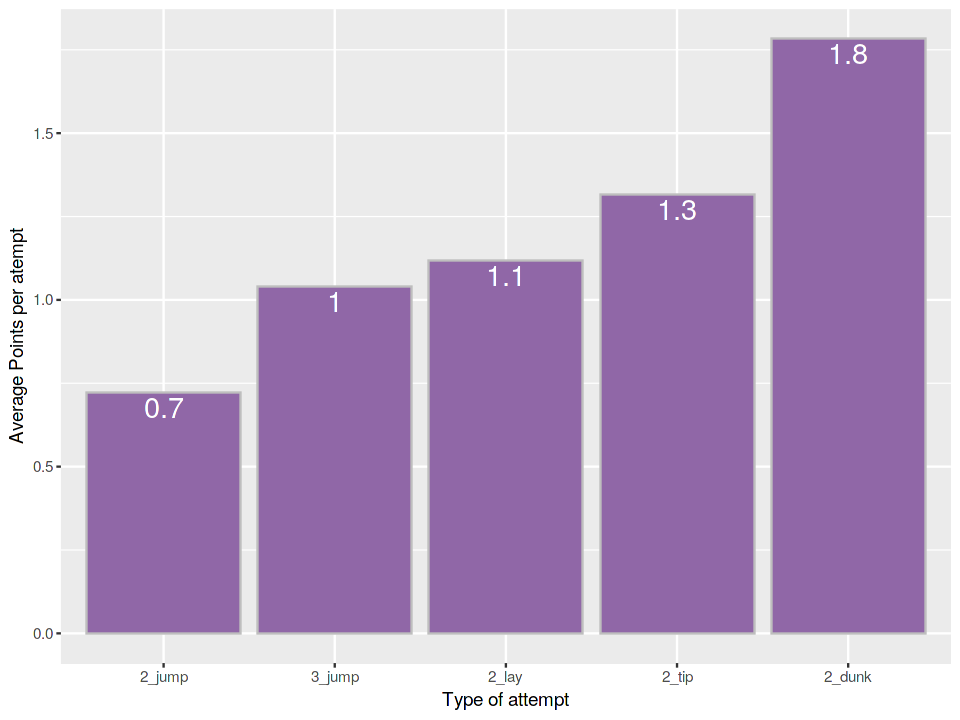

In [4]:
fig(8,6)
#Effectiveness
shot_values <- play_by_play %>% 
  filter(FGVariable == "Yes") %>% 
  mutate(EventType = str_remove(EventType, "made"), EventType = str_remove(EventType, "miss")) %>% 
  group_by(EventType, shot_outcome) %>% 
  summarise(n_attempts = n()) %>% 
  mutate(ShootingPercentage = n_attempts / sum(n_attempts),
         n_attempts = sum(n_attempts)) %>% 
  filter(shot_outcome == "Made") %>% select(-shot_outcome)

shot_values %>% 
  mutate(Point = as.numeric(str_extract(EventType, "[[:digit:]]"))) %>% 
  mutate(ExpectedPoints = ShootingPercentage * Point) %>% 
  ggplot(aes(x=reorder(EventType, ExpectedPoints), y= ExpectedPoints)) +
  ylab("Average Points per atempt") + xlab("Type of attempt") +
  geom_col(fill = "#9067A7", colour = "grey") +
  geom_text(aes(label = round(ExpectedPoints, 1)), vjust =  1.2, colour = "white", size=6)

Another potentially revealing aspect of an interesting game is the total points scored during the match. Do higher seeds, with their honed offensive abilities to crush their opponents, increase the average number of points in a match? Or, on the contrary, do higher seeds often find themselves in stalemates with teams that have extremely effective defensive strategies? Read on as we attempt to examine this in what follows!

In [5]:
Teams1<-unique(play_by_play %>% group_by(Season,WTeamID,LTeamID) %>% select(Season,WTeamID,LTeamID,WFinalScore,LFinalScore))
Teams2<-data.frame(Teams1)

Seeded_t1 <- Teams1 %>% 
  merge(tourney_seeds, by.x = c("Season", "WTeamID"), by.y=c("Season", "TeamID")) 
Seeded_t2 <- Teams2 %>% 
  merge(tourney_seeds, by.x = c("Season", "LTeamID"), by.y=c("Season", "TeamID")) 

Seeded_t1$Region<-str_sub(Seeded_t1$Seed,1,1)
Seeded_t1$Seed<-str_sub(Seeded_t1$Seed,2,str_length(Seeded_t1$Seed))
Seeded_t1<-subset(Seeded_t1,(str_sub(Seeded_t1$Seed,-1,-1)!="b")&(str_sub(Seeded_t1$Seed,-1,-1)!="c"))
Seeded_t1$Seed<-str_sub(Seeded_t1$Seed,1,2)
Seeded_t2$Region<-str_sub(Seeded_t2$Seed,1,1)
Seeded_t2$Seed<-str_sub(Seeded_t2$Seed,2,str_length(Seeded_t2$Seed))
Seeded_t2<-subset(Seeded_t2,(str_sub(Seeded_t2$Seed,-1,-1)!="b")&(str_sub(Seeded_t2$Seed,-1,-1)!="c"))
Seeded_t2$Seed<-str_sub(Seeded_t2$Seed,1,2)

Seeded_t<-rbind(Seeded_t1,Seeded_t2)
Seeded_t$TotScore <- as.numeric(Seeded_t$WFinalScore + Seeded_t$LFinalScore)

After having isolated each match and calculated its total score, we compute the averages for each seed.

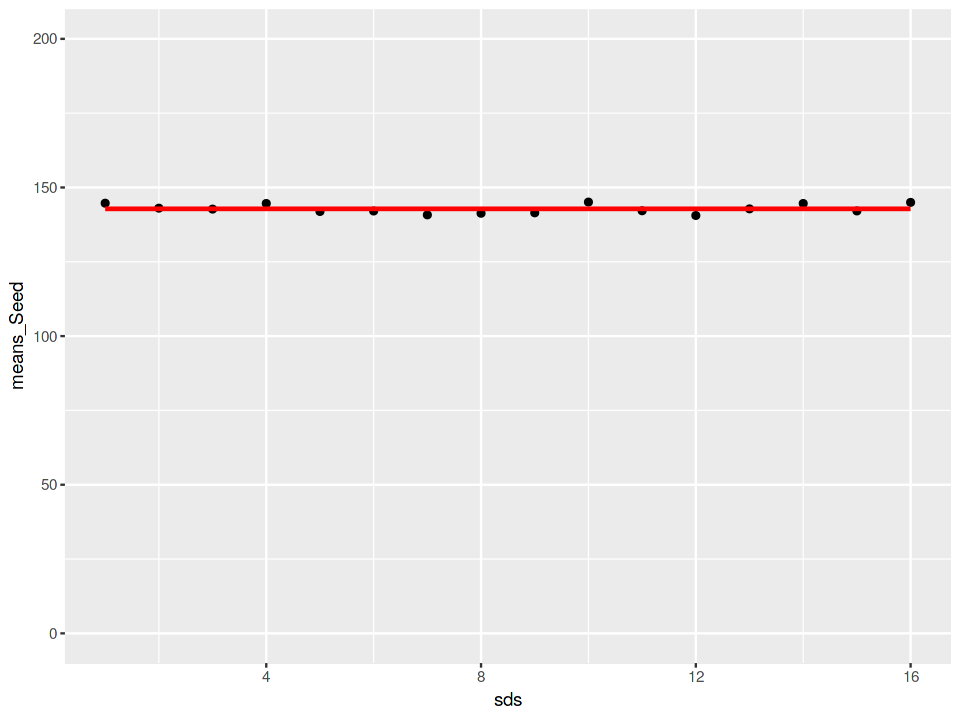

In [6]:
#Mean of points in game, per seed (sum )
Seeded_t$Seed<-as.numeric(Seeded_t$Seed)
sds<-seq(1,16)
means_Seed<-c()
for (i in sds) {
  means_Seed[i]=mean(filter(Seeded_t,Seeded_t$Seed==i)$TotScore)
}
suppressMessages(print(data.frame(sds,means_Seed) %>%
  ggplot(aes(sds,means_Seed)) + geom_point() + expand_limits(y=c(0,200)) + geom_smooth(method="lm", se=FALSE, color="red")))

Surprisingly, we see that this average is pretty much constant over all seeds! We then consider that the two scenarios described previously would present themselves through a high variance for higher seeds. Alternatively, perhaps the unpredictability of teams with a lower seed could increase the standard error. However, we notice that again, that there seems to be no clear trend in either direction based on our analysis.

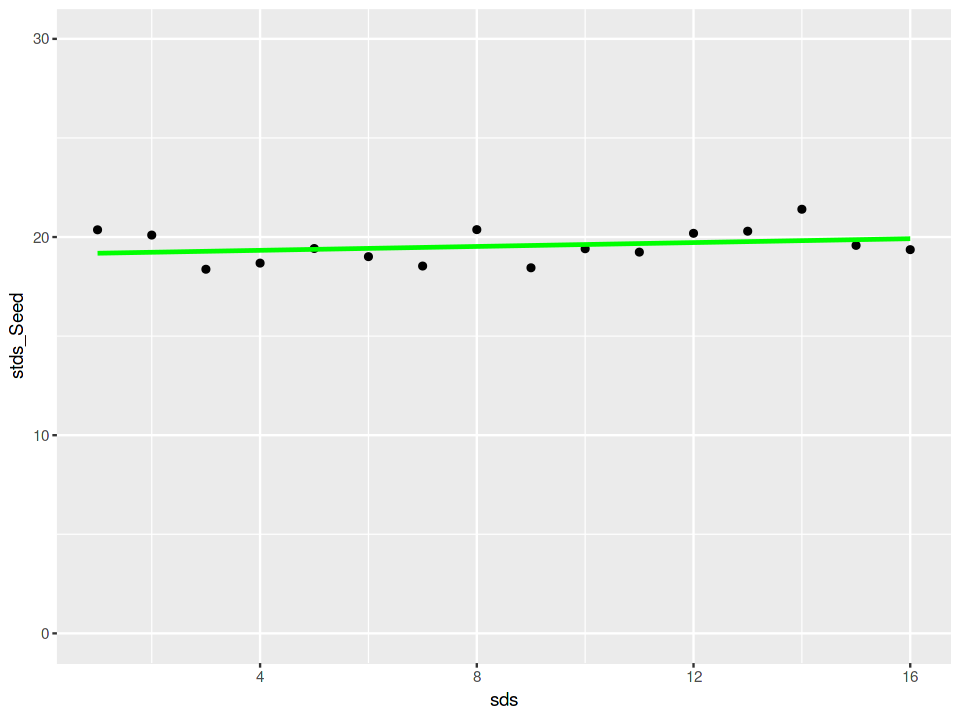

In [7]:
stds_Seed<-c()
for (i in sds) {
  stds_Seed[i]=sd(filter(Seeded_t,Seeded_t$Seed==i)$TotScore) 
}
suppressMessages(print(data.frame(sds,stds_Seed) %>%
  ggplot(aes(sds,stds_Seed)) + geom_point() + expand_limits(y=c(0,30))+ geom_smooth(method="lm", se=FALSE, color="green")))

We have looked at the total points scored in the game, which seemed to be relatively consistent across the board. But maybe that is not the case for each individual team.

In [8]:
#check by teams
Teams<-Teams1 %>% merge(tourney_seeds, by.x=c("Season","WTeamID"),by.y = c("Season","TeamID"))
names(Teams)[names(Teams)=="Seed"]<-"WSeed"
Teams<-Teams %>% merge(tourney_seeds, by.x=c("Season","LTeamID"),by.y = c("Season","TeamID"))
names(Teams)[names(Teams)=="Seed"]<-"LSeed"

Teams$WRegion<-str_sub(Teams$WSeed,1,1)
Teams$WSeed<-str_sub(Teams$WSeed,2,str_length(Teams$WSeed))
Teams<-subset(Teams,(str_sub(Teams$WSeed,-1,-1)!="b")&(str_sub(Teams$WSeed,-1,-1)!="c"))
Teams$WSeed<-str_sub(Teams$WSeed,1,2)
Teams$LRegion<-str_sub(Teams$LSeed,1,1)
Teams$LSeed<-str_sub(Teams$LSeed,2,str_length(Teams$LSeed))
Teams<-subset(Teams,(str_sub(Teams$LSeed,-1,-1)!="b")&(str_sub(Teams$LSeed,-1,-1)!="c"))
Teams$LSeed<-str_sub(Teams$LSeed,1,2)

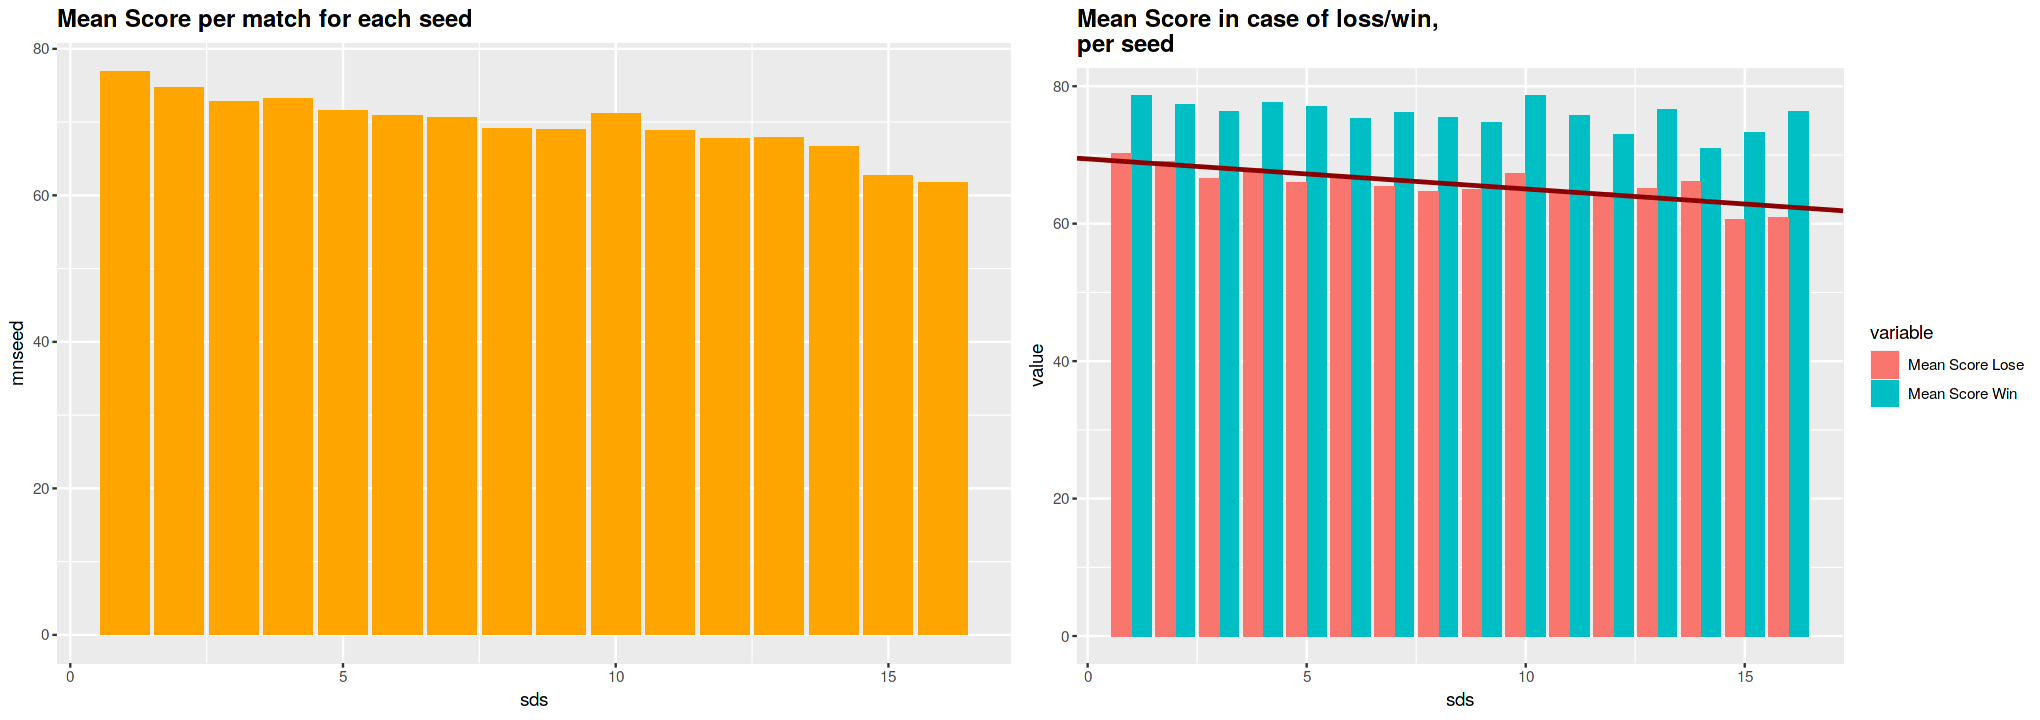

In [9]:
fig(17,6)
Teams$WSeed<-as.numeric(Teams$WSeed)
Teams$LSeed<-as.numeric(Teams$LSeed)
mnseed<-c()
mnswseed<-c()
mnslseed<-c()
for (i in sds) {
  mnseed[i]<-(sum(filter(Teams,Teams$WSeed==i)$WFinalScore)+sum(filter(Teams,Teams$LSeed==i)$LFinalScore))/(nrow(filter(Teams,Teams$WSeed==i))+nrow(filter(Teams,Teams$LSeed==i)))
  mnswseed[i]=mean(filter(Teams,Teams$WSeed==i)$WFinalScore)
  mnslseed[i]=mean(filter(Teams,Teams$LSeed==i)$LFinalScore)
}
df1<-data.frame(sds,mnswseed,mnslseed)
df2<-tidyr::pivot_longer(df1, cols=c('mnswseed','mnslseed'), names_to='variable', values_to="value")
r1 <- lm(mnswseed ~ sds, data = df1)
r2 <- lm(mnslseed ~sds, data = df1)

p1 <- data.frame(sds,mnseed) %>% ggplot(aes(sds,mnseed)) + geom_bar(stat='identity') +geom_col(fill='orange') +ggtitle("Mean Score per match for each seed")+ theme(plot.title = element_text(size=14, face="bold"))
p2 <- ggplot(df2, aes(sds, value, fill=variable)) + geom_bar(stat='identity', position='dodge')+ scale_fill_discrete(labels=c("Mean Score Lose","Mean Score Win"))+ggtitle("Mean Score in case of loss/win, \nper seed")+ theme(plot.title = element_text(size=14, face="bold")) + geom_abline(slope=r2$coefficients[2],intercept = r2$coefficients[1],size=1,color='dark red')

grid.arrange(p1,p2,ncol=2)

As expected, our analysis reveals that teams with higher seeds tend to score more on average than lower ranking teams. What is surprising, however, is that, when comparing games in which the outcome is as expected (a higher ranked seed beats a lower ranked seed), everyone seems to win with as many points! However, when a lower seeded team loses, it will have a much lower average score than when a higher seeded team loses. This can be understood by the fact that, to win, a team will require a given number of points (at least enough to beat the other team!); however, when losing, there is no limit on how little they can lose with! Teams that don't function as well will therefore tend to lose by larger margins, but will not necessarily win with smaller scores.

Finally, we look at the correlation between a team's seed and its predisposition for engaging in unasisted actions - in other words, in its reliance on sparks of genius from a select subset of its players rather than the collaboration between all of its members.

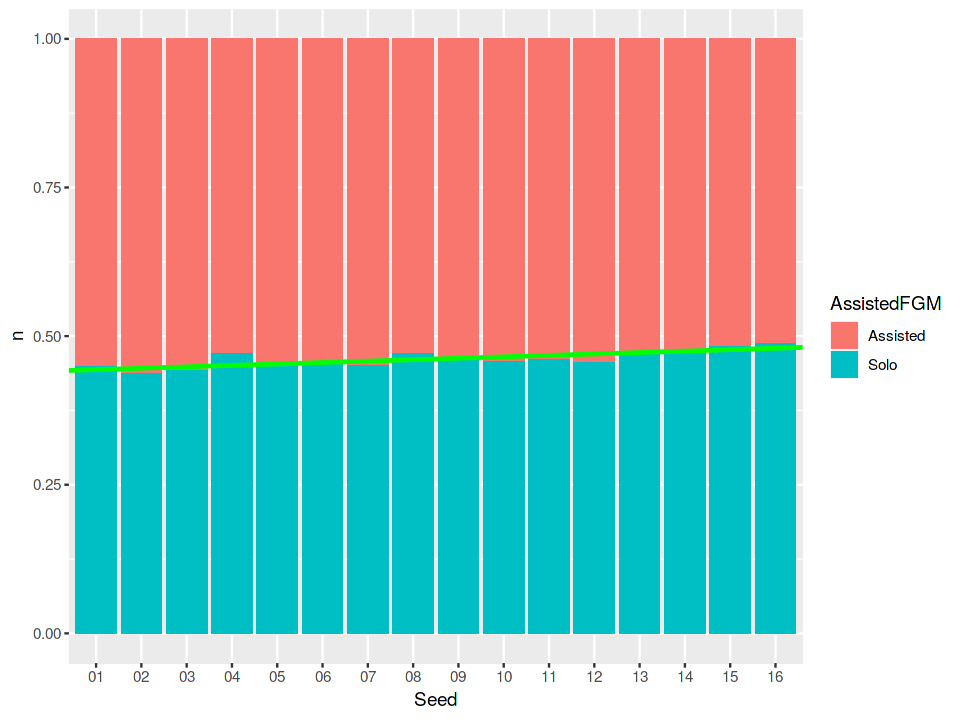

In [10]:
fig(8,6)
Seeded_a <- play_by_play %>% 
  select(EventType,TeamID = EventTeamID,shot_outcome,Season, tot_score,AssistedFGM) %>%
  filter(play_by_play$AssistedFGM!="None") %>%
  merge(tourney_seeds, by = c("Season", "TeamID"))

Seeded_a$Region<-str_sub(Seeded_a$Seed,1,1)
Seeded_a$Seed<-str_sub(Seeded_a$Seed,2,str_length(Seeded_a$Seed))
Seeded_a<-subset(Seeded_a,(str_sub(Seeded_a$Seed,-1,-1)!="b")&(str_sub(Seeded_a$Seed,-1,-1)!="c"))
Seeded_a$Seed<-str_sub(Seeded_a$Seed,1,2)

Assists <-Seeded_a %>% group_by(Seed) %>% count(AssistedFGM)

for (i in sds){
  Assists$n[2*i-1]=(Assists$n[2*i-1])/(Assists$n[2*i-1]+Assists$n[2*i])
  Assists$n[2*i]=1-Assists$n[2*i-1]
}

reg<-lm(n~as.numeric(Seed), data = filter(Assists,AssistedFGM!="Assisted"))


Assists %>% ggplot(aes(x=Seed , y=n, fill=AssistedFGM)) + geom_bar(stat='identity') + geom_abline(slope=reg$coefficients[2],intercept = reg$coefficients[1],size=1,color='green')

As is seen above, when looking at the proportion of assisted to unassisted actions a team takes during a game, it appears that a lower seeded team will tend to rely more on unassisted plays. Intuitively, this makes sense: a higher seeded team is equipped with a complete squad of outstanding players who can work in concert to carry out powerful team plays and score in effective ways (such as the dunks we saw earlier!). However, a lower seeded team will need to hope their main player performs well on its solo plays. This also explains the higher number of long distance 3-point shots which are less effective in general and can be taken as a sign of the team running out of options during an offensive play.

## 2.2. Madness through Unpredictability

As we mentioned, one of the main contributers to "madness" is the unpredictability of matches during the tournament. If all outcomes were guaranteed from the start, no one would enjoy watching the competition, and the name "March Madness" would likely not be appropriate! In order to look into what influences a team being predicted to win or lose or game, we use the [winning model of the 2018 March Madness Predictions competition](https://github.com/fakyras/ncaa_women_2018), built by [Raddar](https://www.kaggle.com/raddar), and try to evaluate what were the most important features in its decision-making. Particularly, we will try to differentiate between situations that lead to predictions of a tight game, and situations that lead to predictions of a landslide victory.

We therefore begin by creating predictions for this year's tournament, using the 2020 analytics competition data.

In [11]:
library(dplyr)
library(xgboost)
library(lme4)

regresults <- read.csv("../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
results <- read.csv("../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv")
sub <- read.csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv")
seeds <- read.csv("../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneySeeds.csv")

seeds$Seed = as.numeric(substring(seeds$Seed,2,4))


### Collect regular season results - double the data by swapping team positions

r1 = regresults[, c("Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore", "NumOT", "WFGA", "WAst", "WBlk", "LFGA", "LAst", "LBlk")]
r2 = regresults[, c("Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT", "LFGA", "LAst", "LBlk", "WFGA", "WAst", "WBlk")]
names(r1) = c("Season", "DayNum", "T1", "T1_Points", "T2", "T2_Points", "NumOT", "T1_fga", "T1_ast", "T1_blk", "T2_fga", "T2_ast", "T2_blk")
names(r2) = c("Season", "DayNum", "T1", "T1_Points", "T2", "T2_Points", "NumOT", "T1_fga", "T1_ast", "T1_blk", "T2_fga", "T2_ast", "T2_blk")
regular_season = rbind(r1, r2)


### Collect tourney results - double the data by swapping team positions

t1 = results[, c("Season", "DayNum", "WTeamID", "LTeamID", "WScore", "LScore")] %>% mutate(ResultDiff = WScore - LScore)
t2 = results[, c("Season", "DayNum", "LTeamID", "WTeamID", "LScore", "WScore")] %>% mutate(ResultDiff = LScore - WScore)
names(t1) = c("Season", "DayNum", "T1", "T2", "T1_Points", "T2_Points", "ResultDiff")
names(t2) = c("Season", "DayNum", "T1", "T2", "T1_Points", "T2_Points", "ResultDiff")
tourney = rbind(t1, t2)


### Fit GLMM on regular season data (selected march madness teams only) - extract random effects for each team

march_teams = select(seeds, Season, Team = TeamID)
X =  regular_season %>% 
  inner_join(march_teams, by = c("Season" = "Season", "T1" = "Team")) %>% 
  inner_join(march_teams, by = c("Season" = "Season", "T2" = "Team")) %>% 
  select(Season, T1, T2, T1_Points, T2_Points, NumOT) %>% distinct()
X$T1 = as.factor(X$T1)
X$T2 = as.factor(X$T2)

quality = list()
for (season in unique(X$Season)) {
  glmm = glmer(I(T1_Points > T2_Points) ~  (1 | T1) + (1 | T2), data = X[X$Season == season & X$NumOT == 0, ], family = binomial) 
  random_effects = ranef(glmm)$T1
  quality[[season]] = data.frame(Season = season, Team_Id = as.numeric(row.names(random_effects)), quality = exp(random_effects[,"(Intercept)"]))
}
quality = do.call(rbind, quality)


### Regular season statistics

season_summary = 
  regular_season %>%
  mutate(win14days = ifelse(DayNum > 118 & T1_Points > T2_Points, 1, 0),
         last14days = ifelse(DayNum > 118, 1, 0)) %>% 
  group_by(Season, T1) %>%
  summarize(
    WinRatio14d = sum(win14days) / sum(last14days),
    PointsMean = mean(T1_Points),
    PointsMedian = median(T1_Points),
    PointsDiffMean = mean(T1_Points - T2_Points),
    FgaMean = mean(T1_fga), 
    FgaMedian = median(T1_fga),
    FgaMin = min(T1_fga), 
    FgaMax = max(T1_fga), 
    AstMean = mean(T1_ast), 
    BlkMean = mean(T1_blk), 
    OppFgaMean = mean(T2_fga), 
    OppFgaMin = min(T2_fga)  
  )

season_summary_X1 = season_summary
season_summary_X2 = season_summary
names(season_summary_X1) = c("Season", "T1", paste0("X1_",names(season_summary_X1)[-c(1,2)]))
names(season_summary_X2) = c("Season", "T2", paste0("X2_",names(season_summary_X2)[-c(1,2)]))


### Combine all features into a data frame

data_matrix =
  tourney %>% 
  left_join(season_summary_X1, by = c("Season", "T1")) %>% 
  left_join(season_summary_X2, by = c("Season", "T2")) %>%
  left_join(select(seeds, Season, T1 = TeamID, Seed1 = Seed), by = c("Season", "T1")) %>% 
  left_join(select(seeds, Season, T2 = TeamID, Seed2 = Seed), by = c("Season", "T2")) %>% 
  mutate(SeedDiff = Seed1 - Seed2) %>%
  left_join(select(quality, Season, T1 = Team_Id, quality_march_T1 = quality), by = c("Season", "T1")) %>%
  left_join(select(quality, Season, T2 = Team_Id, quality_march_T2 = quality), by = c("Season", "T2"))


### Prepare xgboost 

features = setdiff(names(data_matrix), c("Season", "DayNum", "T1", "T2", "T1_Points", "T2_Points", "ResultDiff"))
dtrain = xgb.DMatrix(as.matrix(data_matrix[, features]), label = data_matrix$ResultDiff)

cauchyobj <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  c <- 5000 
  x <-  preds-labels
  grad <- x / (x^2/c^2+1)
  hess <- -c^2*(x^2-c^2)/(x^2+c^2)^2
  return(list(grad = grad, hess = hess))
}

xgb_parameters = 
  list(objective = cauchyobj, 
       eval_metric = "mae",
       booster = "gbtree", 
       eta = 0.02,
       subsample = 0.35,
       colsample_bytree = 0.7,
       num_parallel_tree = 10,
       min_child_weight = 40,
       gamma = 10,
       max_depth = 3)

N = nrow(data_matrix)
fold5list = c(
  rep( 1, floor(N/5) ),
  rep( 2, floor(N/5) ),
  rep( 3, floor(N/5) ),
  rep( 4, floor(N/5) ),
  rep( 5, N - 4*floor(N/5) )
)


### Build cross-validation model, repeated 10-times

iteration_count = c()
smooth_model = list()

for (i in 1:10) {
  
  ### Resample fold split
  set.seed(i)
  folds = list()  
  fold_list = sample(fold5list)
  for (k in 1:5) folds[[k]] = which(fold_list == k)
  
  set.seed(120)
  xgb_cv = 
    xgb.cv(
      params = xgb_parameters,
      data = dtrain,
      nrounds = 3000,
      verbose = 0,
      nthread = 12,
      folds = folds,
      early_stopping_rounds = 25,
      maximize = FALSE,
      prediction = TRUE
    )
  iteration_count = c(iteration_count, xgb_cv$best_iteration)
  
  ### Fit a smoothed GAM model on predicted result point differential to get probabilities
  smooth_model[[i]] = smooth.spline(x = xgb_cv$pred, y = ifelse(data_matrix$ResultDiff > 0, 1, 0))
  
}


### Build submission models

submission_model = list()

for (i in 1:10) {
  set.seed(i)
  submission_model[[i]] = 
    xgb.train(
      params = xgb_parameters,
      data = dtrain,
      nrounds = round(iteration_count[i]*1.05),
      verbose = 0,
      nthread = 12,
      maximize = FALSE,
      prediction = TRUE
    )
}


### Run predictions

sub$Season = 2019
sub$T1 = as.numeric(substring(sub$ID,6,9))
sub$T2 = as.numeric(substring(sub$ID,11,14))

Z = sub %>% 
  left_join(season_summary_X1, by = c("Season", "T1")) %>% 
  left_join(season_summary_X2, by = c("Season", "T2")) %>%
  left_join(select(seeds, Season, T1 = TeamID, Seed1 = Seed), by = c("Season", "T1")) %>% 
  left_join(select(seeds, Season, T2 = TeamID, Seed2 = Seed), by = c("Season", "T2")) %>% 
  mutate(SeedDiff = Seed1 - Seed2) %>%
  left_join(select(quality, Season, T1 = Team_Id, quality_march_T1 = quality), by = c("Season", "T1")) %>%
  left_join(select(quality, Season, T2 = Team_Id, quality_march_T2 = quality), by = c("Season", "T2"))

dtest = xgb.DMatrix(as.matrix(Z[, features]))

probs = list()
for (i in 1:10) {
  preds = predict(submission_model[[i]], dtest)
  probs[[i]] = predict(smooth_model[[i]], preds)$y
}
Z$Pred = Reduce("+", probs) / 10

### Better be safe than sorry
Z$Pred[Z$Pred <= 0.025] = 0.025
Z$Pred[Z$Pred >= 0.975] = 0.975

### Anomaly event happened only once before - be brave
Z$Pred[Z$Seed1 == 16 & Z$Seed2 == 1] = 0
Z$Pred[Z$Seed1 == 15 & Z$Seed2 == 2] = 0
Z$Pred[Z$Seed1 == 14 & Z$Seed2 == 3] = 0
Z$Pred[Z$Seed1 == 13 & Z$Seed2 == 4] = 0
Z$Pred[Z$Seed1 == 1 & Z$Seed2 == 16] = 1
Z$Pred[Z$Seed1 == 2 & Z$Seed2 == 15] = 1
Z$Pred[Z$Seed1 == 3 & Z$Seed2 == 14] = 1
Z$Pred[Z$Seed1 == 4 & Z$Seed2 == 13] = 1

predictions<-data.frame(Z)



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




As we are attempting to evaluate what makes a game close or not, we choose "stereotypical" games from the prediction charts we have created. "Stereotypical" games are those which are either extremeley unbalanced or extremely close. We do this in the hope of seeing patterns emerge. In particular, we select the "central" 10% of predictions (games where team1 was predicted to win between 45 and 55 percent of time) and the "extreme" 10% of predictions (games where team1 was predicted to win either between 0 and 5 percent of times, or between 95 and 100 percent of time).

In [12]:
predictions$NotCloseGame <- ifelse((predictions$Pred<0.05) | (predictions$Pred>0.95),1,0)
predictions$CloseGame <- ifelse(predictions$Pred>0.45 & predictions$Pred<0.55,1,0)

interesting_pred<-filter(predictions, predictions$NotCloseGame==1 | predictions$CloseGame==1)

It's important for us to be careful here. Even though the percentages are the same, the number of games in each interval might not be. We check this below.

In [13]:
print(paste0("There are ",sum(predictions$NotCloseGame)," matches with win probabilities between 0% and 5%, or between 95% and 100%"))
print(paste0("There are ",sum(predictions$CloseGame)," matches with win probabilities between 45% and 55%"))

[1] "There are 1025 matches with win probabilities between 0% and 5%, or between 95% and 100%"
[1] "There are 3432 matches with win probabilities between 45% and 55%"


And indeed we see that there is a large difference in the number of games within each percentile! If we were working with a normal distribution of probability rates, this would be understandable. What we have here, while not exaclty a normal distribution, still has the property of having a higher density of games predicted in the center percentiles (see below). 

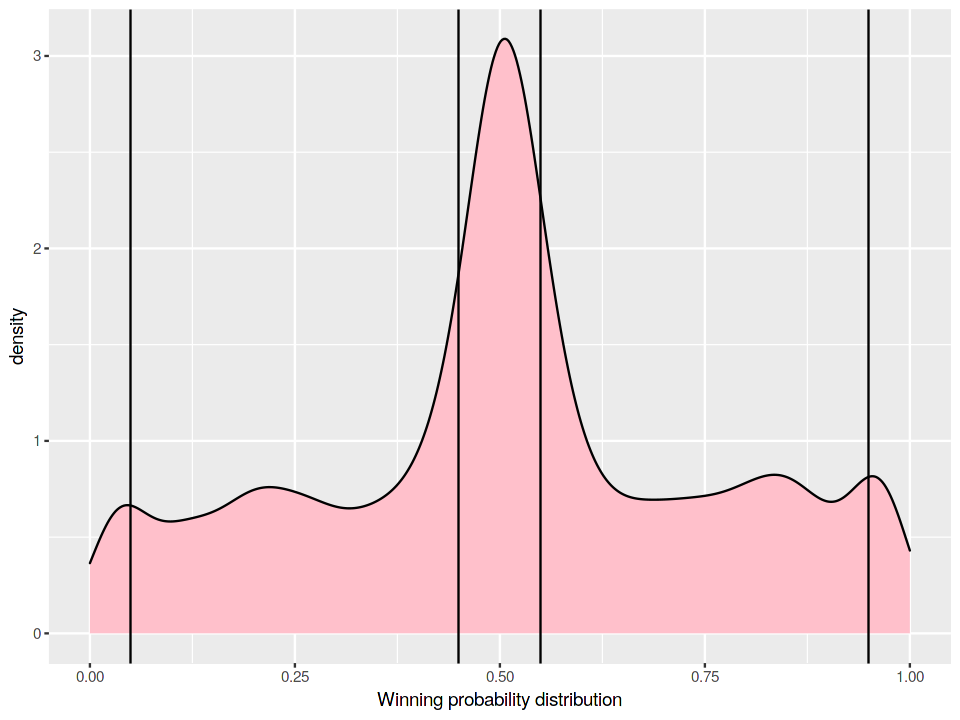

In [14]:
fig(8,6)
ggplot(predictions, aes(Pred)) + geom_density(fill="pink") + geom_vline(xintercept=0.05) + xlab("Winning probability distribution") + geom_vline(xintercept=0.95) + geom_vline(xintercept=0.45) + geom_vline(xintercept=0.55)

To avoid any problems, we choose to instead define intervals with a similar number of games. For this, we take an arbitrary number of games (let's select 2500 games, as that value is between the two we had before), and estimate the best thresholds for the categorical boundaries such that each category will have this number of games.

In [15]:
for (d in seq(0,0.5,by=0.001)) {
  if (sum(ifelse((predictions$Pred<d) | (predictions$Pred>(1-d)),1,0))>=2500){
    thresh_ext=d
    break
  }
}

for (d in seq(0,0.5,by=0.001)) {
  if (sum(ifelse((predictions$Pred>(0.5-d)) & (predictions$Pred<(0.5+d)),1,0))>=2500){
    thresh_int=d
    break
  }
}

predictions$NotCloseGame <- ifelse((predictions$Pred<thresh_ext) | (predictions$Pred>(1-thresh_ext)),1,0)
predictions$CloseGame <- ifelse((predictions$Pred>(0.5-thresh_int)) & (predictions$Pred<(0.5+thresh_int)),1,0)
interesting_pred<-filter(predictions, predictions$NotCloseGame==1 | predictions$CloseGame==1)

print(paste0("We take ",100*thresh_ext,"% of values on each side"))
print(paste0("We take ",200*thresh_int,"% of the central values"))

[1] "We take 15.4% of values on each side"
[1] "We take 6.4% of the central values"


For each of the features of the prediction model, we then plot the corresponding densities of games (both for "central" and "extreme" games), and see what differences can be observed.

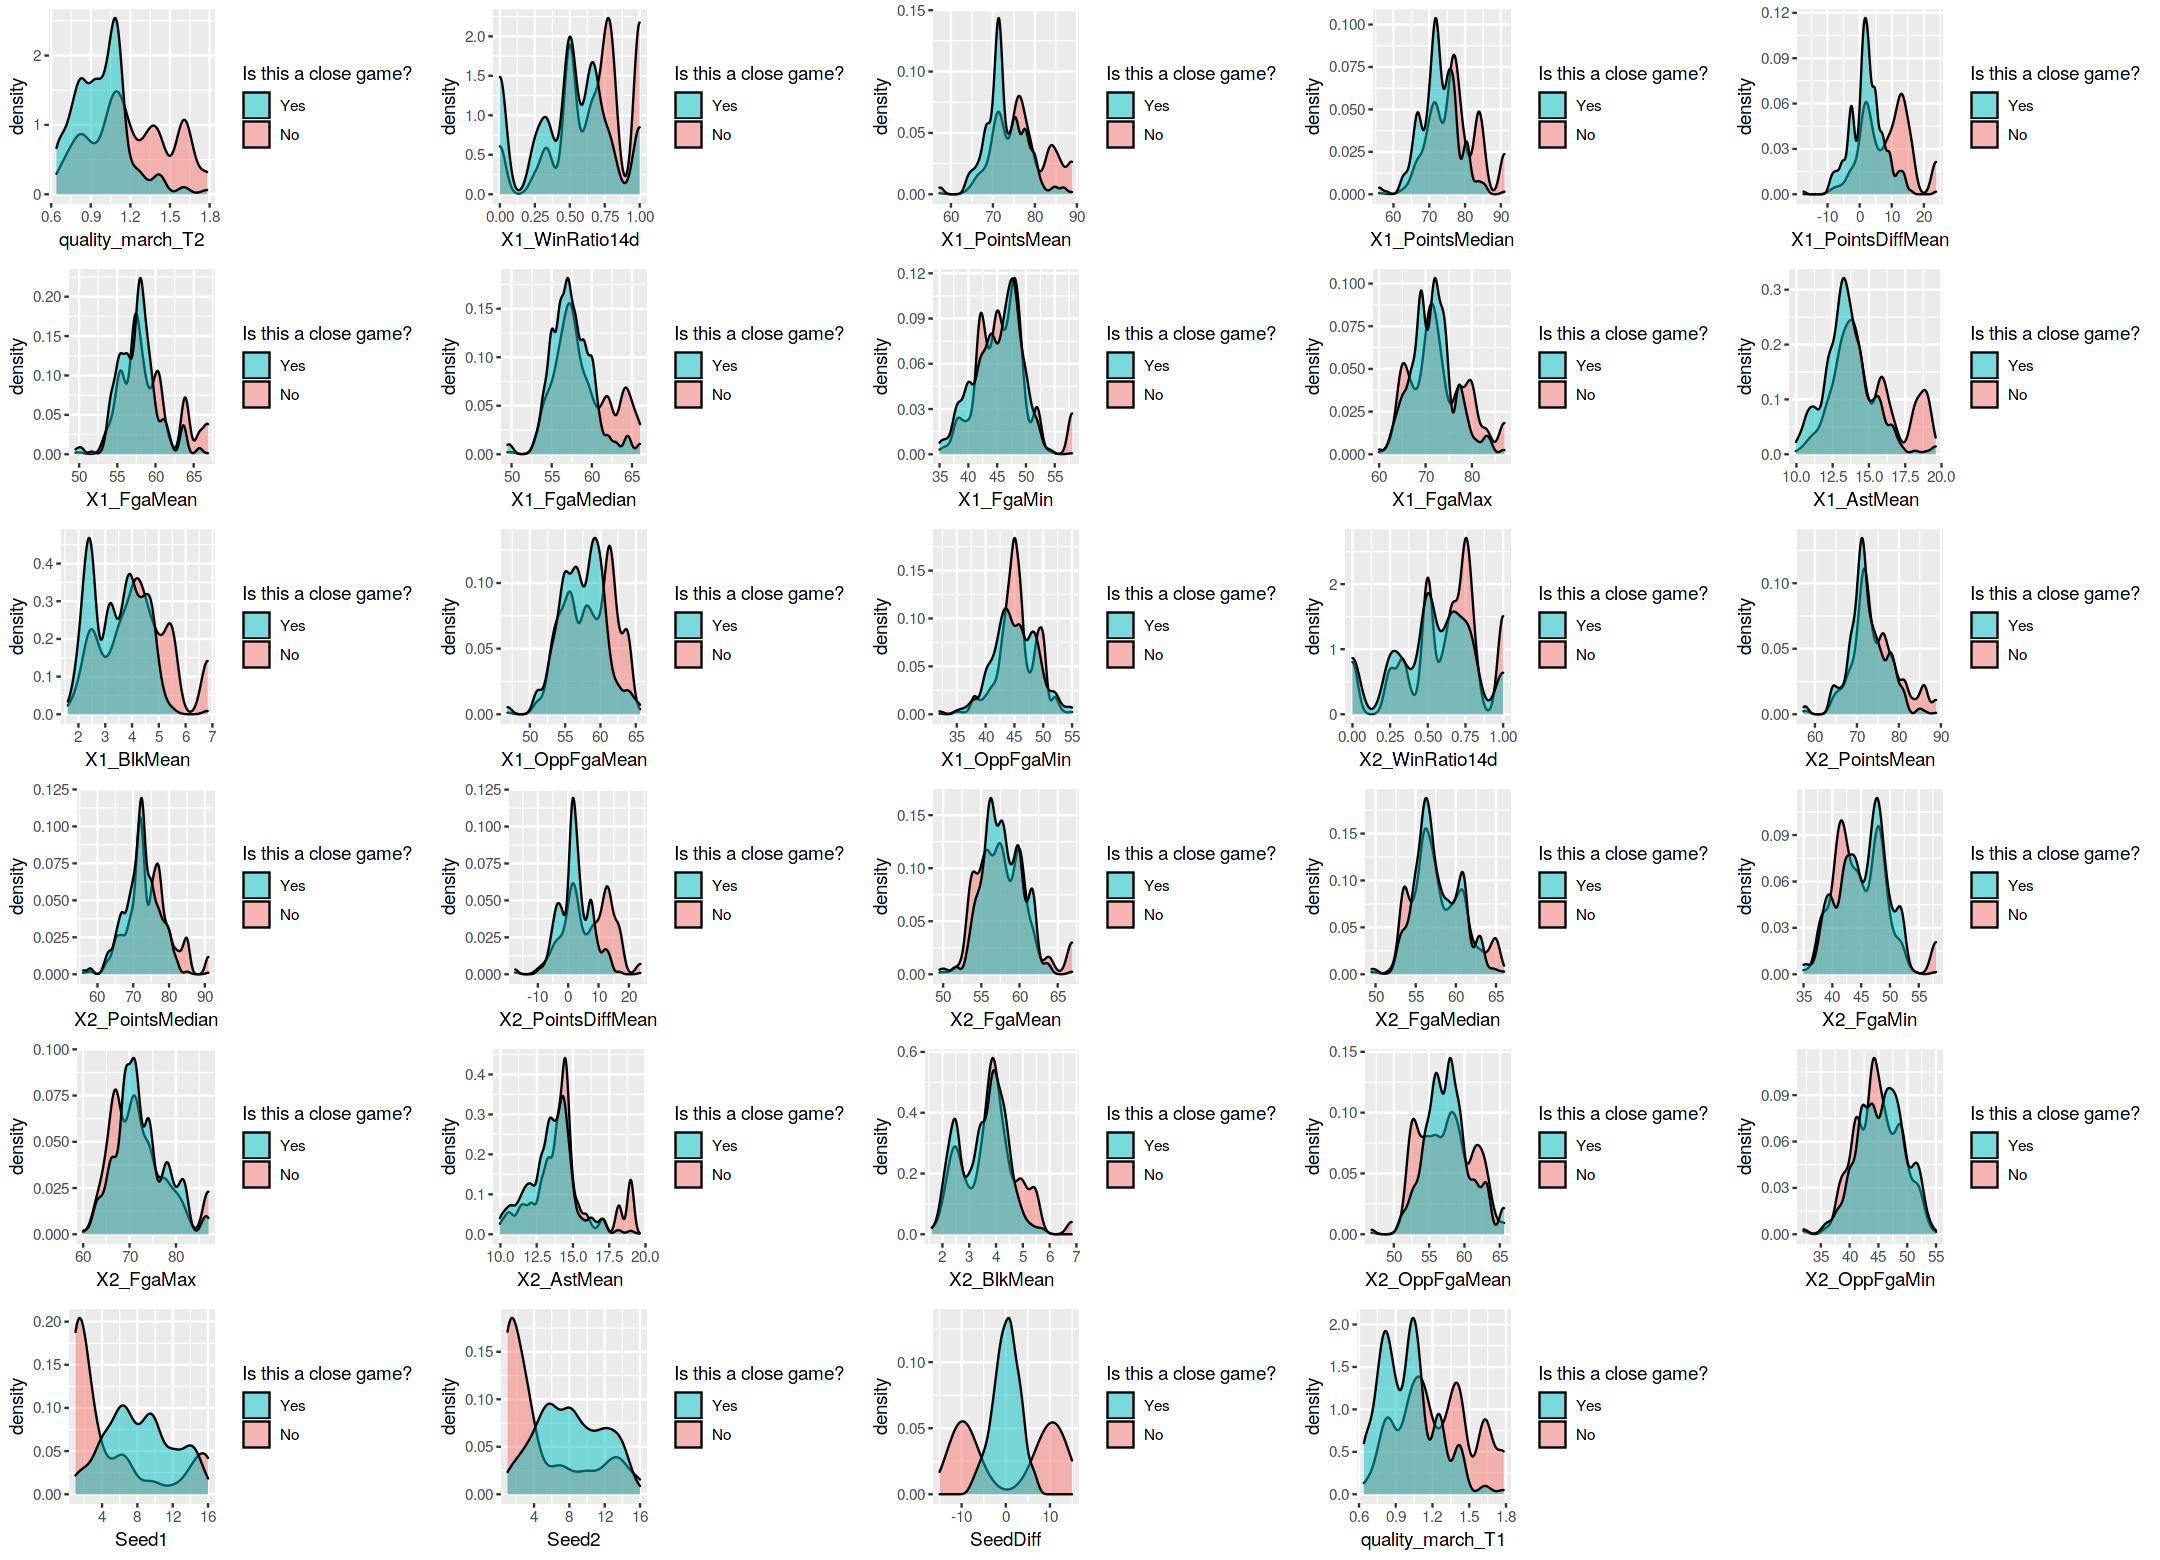

In [16]:
fig(18,13)
grid.newpage() 
pushViewport(viewport(layout = grid.layout(6, 5)))
for (col in (6:33)){
  density<-ggplot(interesting_pred, aes(interesting_pred[,col], fill=factor(CloseGame)))+geom_density(alpha=0.5)+xlab(names(predictions)[col])+ guides(fill=guide_legend(title="Is this a close game?"))+ scale_fill_discrete(breaks=c("1","0"),labels=(c("Yes","No")))
  print(density, vp = viewport(layout.pos.row = 1+(col-5)%/%5, layout.pos.col = 1+(col-5)%%5))
}

density<-ggplot(interesting_pred, aes(interesting_pred[,34], fill=factor(CloseGame)))+geom_density(alpha=0.5)+xlab(names(predictions)[34])+ guides(fill=guide_legend(title="Is this a close game?"))+ scale_fill_discrete(breaks=c("1","0"),labels=(c("Yes","No")))
print(density, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))

Looking at these results, for most of the features, there doesn't appear to be a significant difference between a very close game and a landslide victory. The only feature that seems to directly influence the prediction is the seed. However, it is interesting to notice that, while a team having a high seed almost always means that it will win, the reverse is not true. Teams with low seeds do not have such a high number of uneven games. We can explain this by the fact that, while a higher seeded team will need to always perform well to achieve great results, what characterizes a lower seeded team is not necessarily its repeated bad performances, but rather its inconsistency. This result is also reflected in the "quality_march" features (representing the estimated strength of each team during the last month before the competition), as high quality teams create games which are less close in general.

However, we must also notice that the previous analysis only takes into account features concerning particular teams, while what should matter is actually the difference between the two teams! We set out to evaluate this below. Here, the x-axis represents the absolute difference between each team in a given match, for the considered feature. In particular, this means the density concentrated to the left of the plot indicates a low difference in terms of that feature.

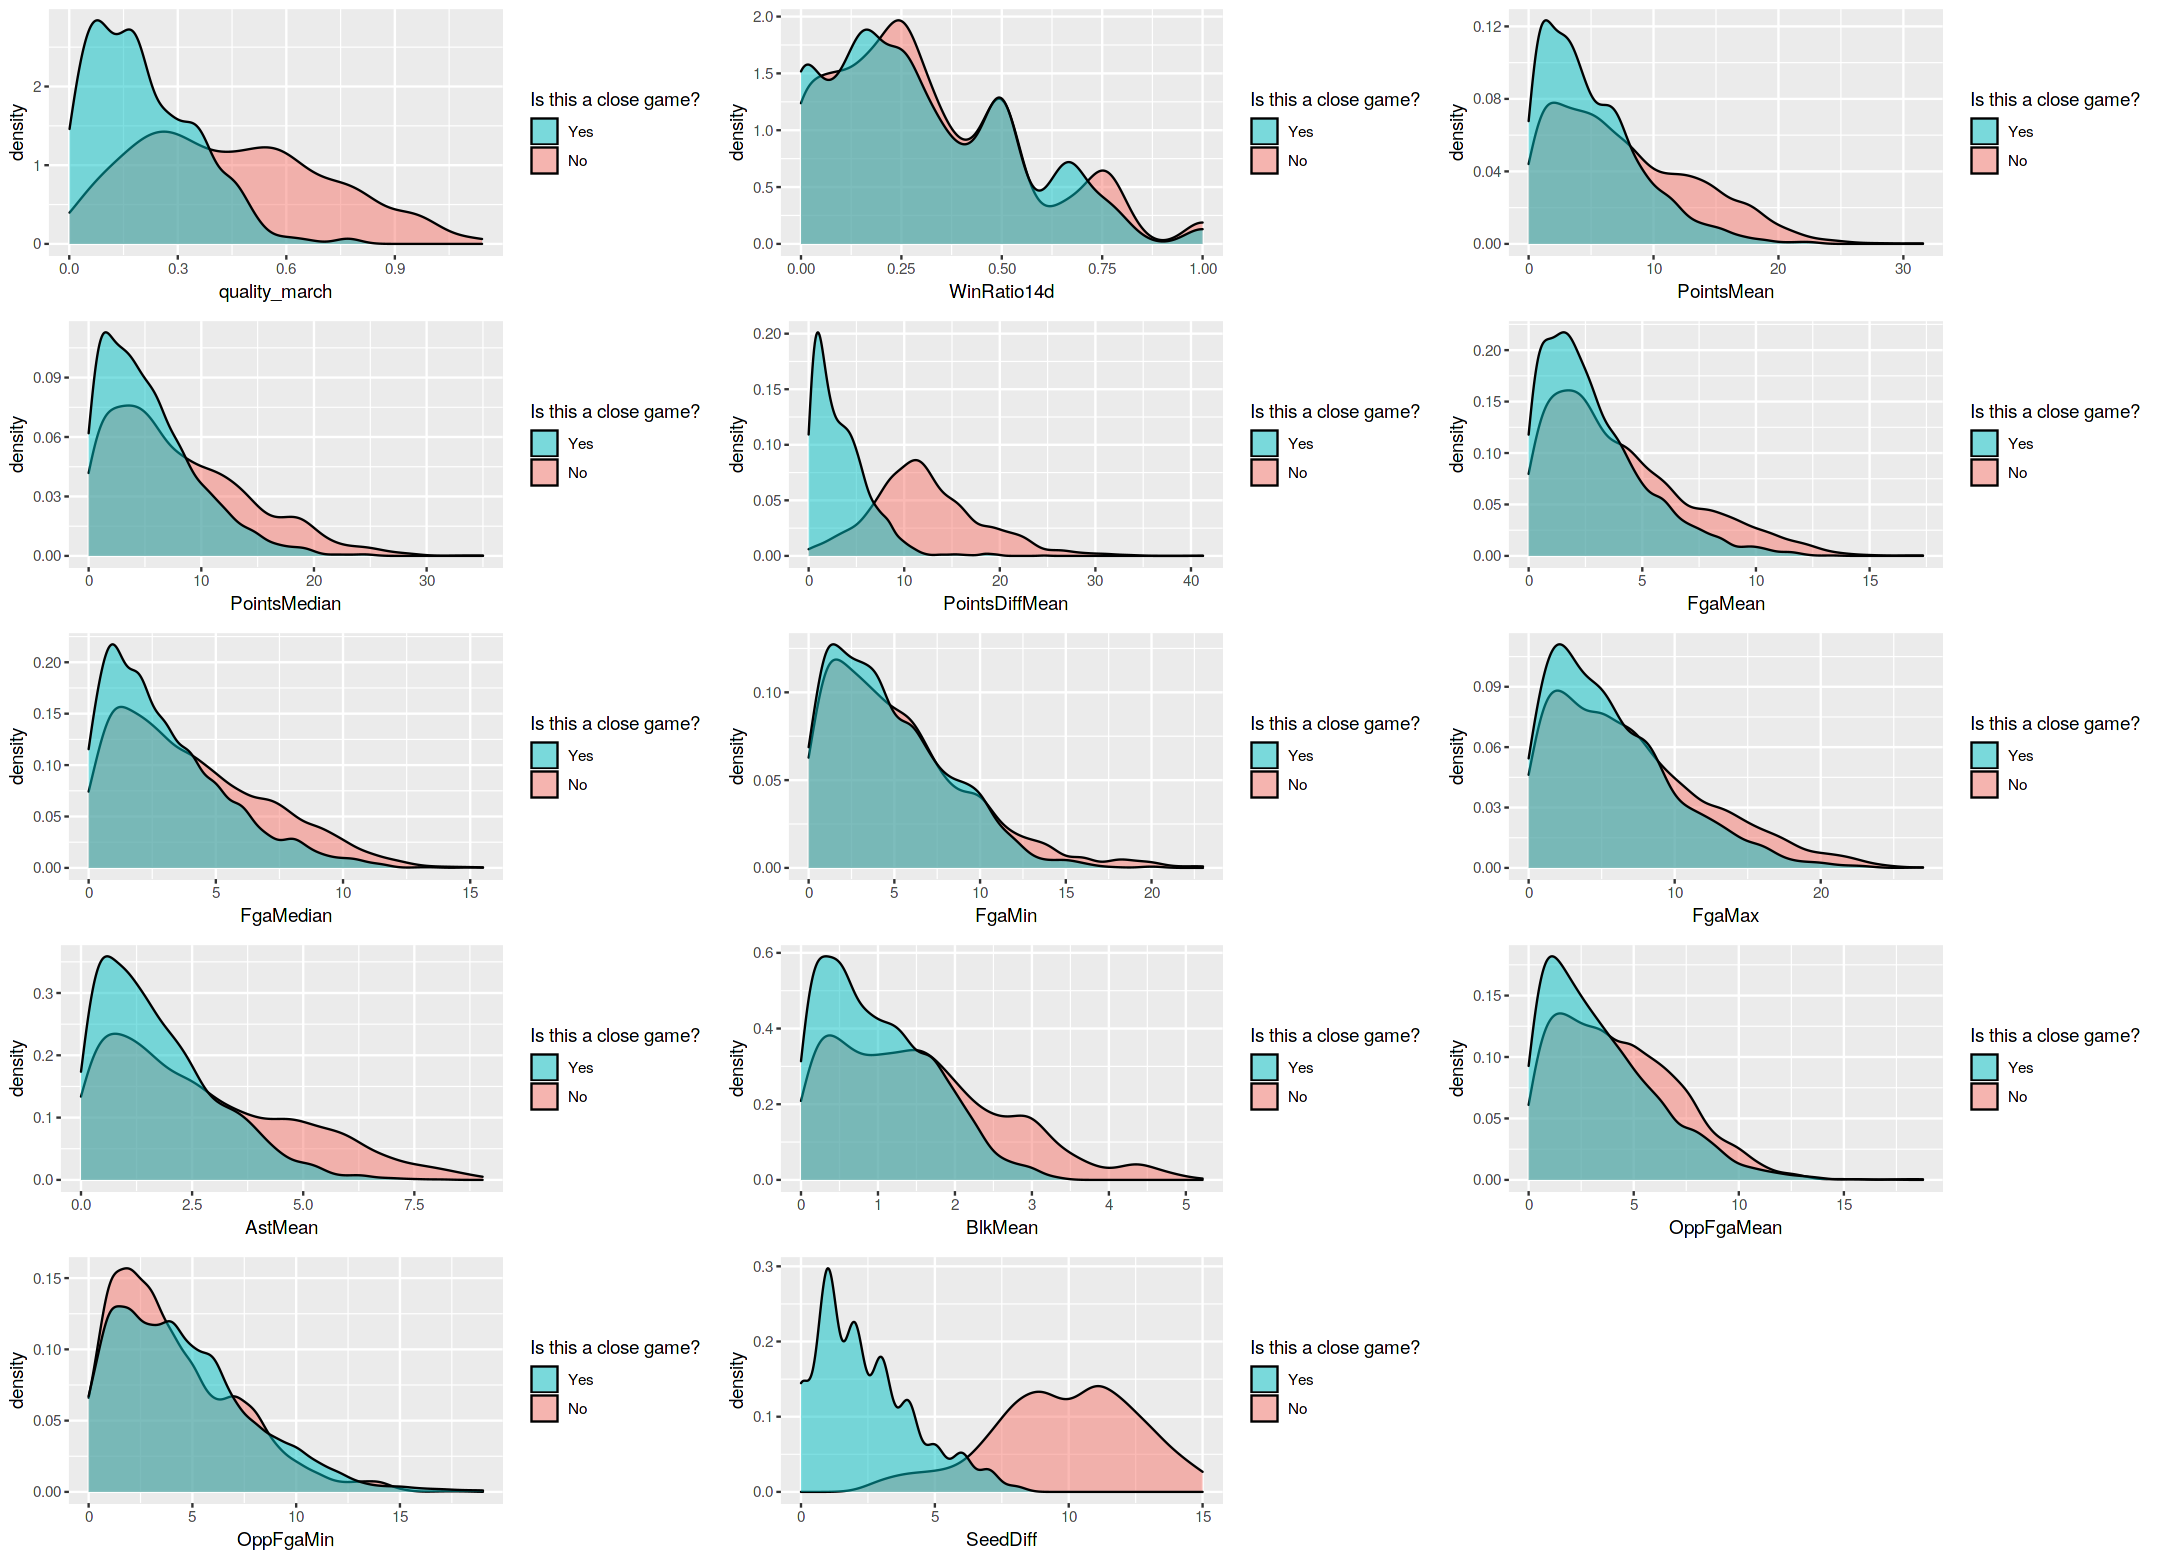

In [17]:
fig(18,13)
grid.newpage() 
pushViewport(viewport(layout = grid.layout(5, 3)))
for (col in (6:17)){
  density<-ggplot(interesting_pred, aes(abs(interesting_pred[,col]-interesting_pred[,col+12]), fill=factor(CloseGame)))+geom_density(alpha=0.5)+xlab(str_sub(names(predictions)[col],-str_length(names(predictions)[col])+3,-1))+ guides(fill=guide_legend(title="Is this a close game?"))+ scale_fill_discrete(breaks=c("1","0"),labels=(c("Yes","No")))
  print(density, vp = viewport(layout.pos.row = 1+(col-5)%/%3, layout.pos.col = 1+(col-5)%%3))
}

density<-ggplot(interesting_pred, aes(abs(interesting_pred[,30]-interesting_pred[,31]), fill=factor(CloseGame)))+geom_density(alpha=0.5)+xlab(names(predictions[32]))+ guides(fill=guide_legend(title="Is this a close game?"))+ scale_fill_discrete(breaks=c("1","0"),labels=(c("Yes","No")))
print(density, vp = viewport(layout.pos.row = 5, layout.pos.col = 2))

density<-ggplot(interesting_pred, aes(abs(interesting_pred[,33]-interesting_pred[,34]), fill=factor(CloseGame)))+geom_density(alpha=0.5)+xlab(str_sub(names(predictions)[33],1,str_length(names(predictions)[33])-3))+ guides(fill=guide_legend(title="Is this a close game?"))+ scale_fill_discrete(breaks=c("1","0"),labels=(c("Yes","No")))
print(density, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))

Here, we see that in most cases, the difference in particular features does not sufficiently explain the decision of the predictor. On the other hand, apart from the seed difference and team quality, which we have already identified as highly influential in terms of the predictions, we also see that the difference in average number of points is a good indicator of which way a game will tip. This fits with our basic intuition, and with the results seen in the previous section where we saw that higher seeded teams tend to score a higher number of points!

In terms of madness, these results do show how unpredictable this whole tournament is. Most of the indicators we would use to characterize teams are not effecient in estimating the winner of a given match. That our analysis reinforces the underlying unpredictability of the games also shows how unique and exciting this period of time is for NCAA fans looking for exitement and a good gamble!

## 2.3. Entertainment Due to the Closeness of the Games

Once again, the purpose of using objective data in Part 1 is to investigate the entertainment due to the play-by-play actions during a game and the ultimate closeness of a match. Those who attend a nail-biter experience the amazing tension generated by the suspense of not knowing the outcome. Those who attend a game that has an outcome that is basically known from the start can still have fun but don't experience the same heightened "madness" that comes from a close match. Unpredictability is magic in the sporting world. As the game moves on, the spectators identify themselves with the players of their favorite team, syncing their eyes, thoughts, and even their breath! When immersed in this type of situation, any single action can be decisive, and the beauty is that it can come from both sides of the court! Complaining, screaming, standing up: these are the natural manifestations of the "madness" of a close basketball game.

Here, we want to obtain a better understanding of the influence of the seed difference on the closeness of a game.

A common assumption is that the closeness of a play is only dependent of the seed differences: when they are high, the game is not close and its results can be inferred even before the game actually takes place, and when they are low, the game is intense throughout the play period. In other words, if suspense is the main driver of the entertainment, madness can only happen in matches between closely seeded teams (whether that's two higher seeded teams facing off or two lower seeded teams going head to head). But is this assumption true? Which metrics should be used to quantify the closeness of a game? How does the difference in seeds drive the closeness throughout a game? And does the trend remain constant over the years or evolve with each season?

These questions will be addressed by continuing to read on. Specifically, we are going to assess the validity of this assuumed trend with three metrics associated with the closeness of a given game: the number of leadership "switches," the last moment the winning team experiences an equal or a lower score than its opponent, and the history of the score range. While it is always possible to explore more complex and subtle metrics, we believe these three are able to capture the necessary information and allow us to easily interpret the main features of the closeness of a game.

This part is divided into two subparts. First, we will describe how we used the NCAA dataset for the Men's competition to build a dataset from which to gather data for a given game (the seed difference of the team involved as well as the three metrics described above). We will describe the case for the season 2015 first which can be scaled into a global routine involving all the seasons. Secondly, we will use the results obtained to evaluate the initial assumption above.

In [18]:
library(zoo)

yextract <- function(string){ 
str_sub(string, -8,-5)
} 



MEventsfile="../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2015.csv" ####################### CAN BE ADAPTED
TourneySeedfile="../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneySeeds.csv"  
infomatch <- read.csv(MEventsfile,stringsAsFactors = FALSE)

SeasonConsidered=as.numeric(yextract(MEventsfile))
seeds <- read.csv(TourneySeedfile, stringsAsFactors = FALSE)


### Step 1 : Building a data set with associated the three closeness metric for a given game

To achieve this goal, we have exploited the Event files which contain the time history play-by-play. These files do not strictly represent the time history of a play, but do contain all the relevant information to reconstruct the time history of a given game. More specifically, we have used the Season, the Day play, and the Winning and Losing Team ID to uniquely identify a play. Then, we have linked this play with its team seed difference, which can be derived using the Tourney seed File.

Practically, two tables have been built: (1) recap_SC which identifies with MatchID all the games during the season with their associated difference of seeds and (2) game_SC which includes all the time history of the MatchID game during the season.


In [19]:
numextract <- function(string){ 
str_extract(string, "\\-*\\d+\\.*\\d*")
} 
## Create recap_SC (SC= Season Considered)
## Table with all the games during the season. Contains the difference of Seeds for each match
seeds_SC=subset(seeds,Season==SeasonConsidered)
mysample <- infomatch %>% select("Season","WTeamID","LTeamID","DayNum")
mysample=unique(mysample)

recap_SC=merge(mysample,seeds_SC,by.x="WTeamID",by.y="TeamID")
recap_SC=select(recap_SC,"Season"="Season.x","WSeed"="Seed","WTeamID","LTeamID","DayNum")
recap_SC=merge(recap_SC,seeds_SC,by.x="LTeamID",by.y="TeamID")
recap_SC=select(recap_SC,"Season"="Season.x","DayNum","WTeamID","LTeamID","WSeed","LSeed"="Seed")
recap_SC$DiffSeed=abs(as.numeric(numextract(recap_SC$WSeed))-as.numeric(numextract(recap_SC$LSeed)))
recap_SC=recap_SC[order(recap_SC$WTeamID),]
recap_SC$MatchID <- seq.int(nrow(recap_SC))

## Create game_SC (SC= Season Considered)
## Table with all the history of the game during the season.  Associated with Match ID
buffer=select(infomatch,"Season","DayNum","WTeamID","LTeamID","WFinalScore","LFinalScore","WCurrentScore","LCurrentScore","ElapsedSeconds")
game_SC=merge(buffer,recap_SC,by=c("Season","DayNum","WTeamID","LTeamID"))
game_SC=select(game_SC,"MatchID","WTeamID","LTeamID","WFinalScore","LFinalScore","WCurrentScore","LCurrentScore","ElapsedSeconds")
game_SC=game_SC[order(game_SC$WTeamID,game_SC$MatchID,game_SC$ElapsedSeconds),]
game_SC["DiffCurrentScore"]=game_SC$WCurrentScore-game_SC$LCurrentScore
game_SC=unique(game_SC)

game_SC %>% head (5)

,MatchID,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,DiffCurrentScore
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
106427,1,1112,1211,66,63,0,0,16,0
106525,1,1112,1211,66,63,0,0,32,0
106511,1,1112,1211,66,63,0,0,58,0
106442,1,1112,1211,66,63,0,2,70,-2
106483,1,1112,1211,66,63,0,2,97,-2


Once this table is built, we will use it to compute, for each play, the three metrics described above.

The first metric represents the number of leadership switches, Nb_Switch. In other words, the number of times throughout a game the winning team switches. This can be inferred by looking at the sign of the score difference between the team one and team two, and counting the number of times the sign goes from positive to negative or from 0 to negative. Thus, Nb_Switch will count the number of times one team changed from winning (with a higher or the same score as the other team) to losing (with a lower score than the other team).

The second metric is the last moment the winning team experiences an equal or a lower score than its opponent, LastSwitch. This metric can estimated from the last moment the score difference is either null or negative. Since the data provided did not have the same period for each game, we have normalized the latter in our plots.

The third and last metric gives an indication of the narrowness of the score range, AUC. It derived from the area of the time history of the score difference. The more imbalanced is the score, the higher AUC will be. Conversely, if the score difference is confined within small range, the AUC will be low.

To clearly understand what these metrics reveal, we have illustrated in the code below four basic game scenarios. We display the results on a table with the metrics defined above.  

MatchID,DiffSeed,Nb_Switch,AUC,LastSwitch
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,100
2,10,0,405,10
3,5,4,90,90
4,1,0,15,100
5,2,1,60,60


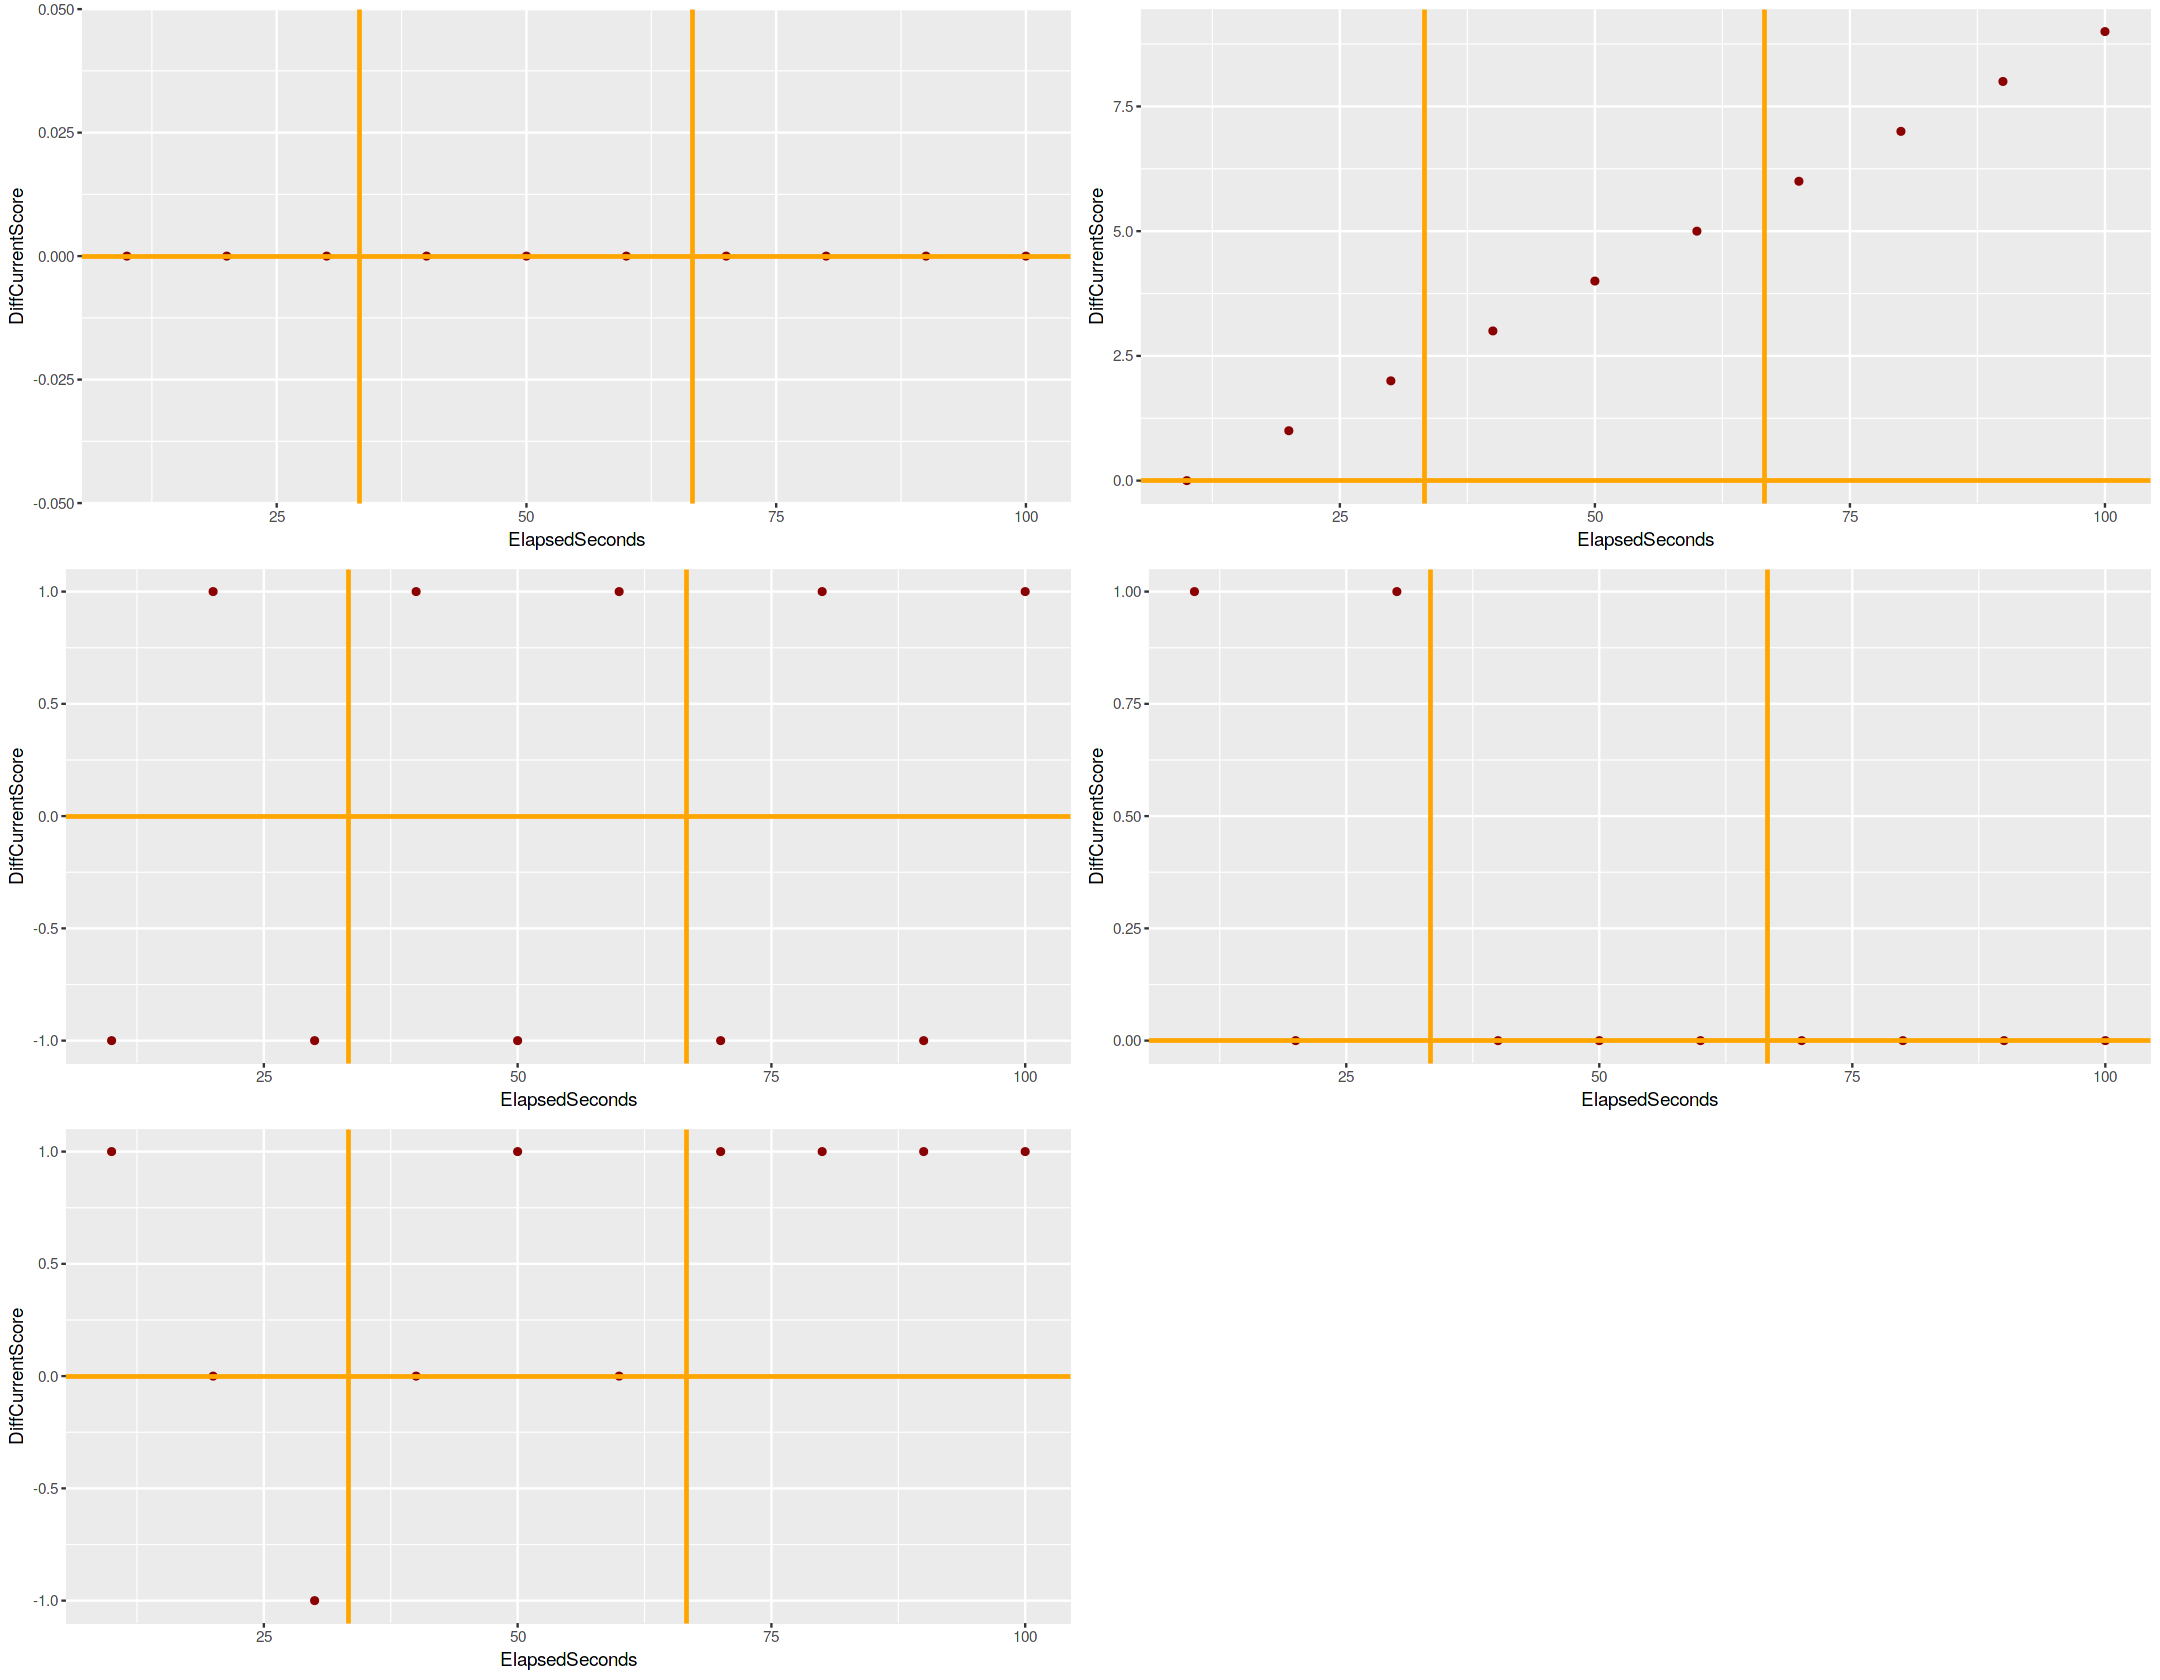

In [20]:
fig(18,14)
grid.newpage() 
pushViewport(viewport(layout = grid.layout(3, 2)))
test_recap_SC=data.frame(MatchID=c(1,2,3,4,5),DiffSeed=c(0,10,5,1,2))
test_game_SC=data.frame(MatchID=c(rep(1,10),rep(2,10),rep(3,10),rep(4,10),rep(5,10)),DiffCurrentScore=c(rep(0,10),c(0:9),c(-1,1,-1,1,-1,1,-1,1,-1,1),c(1,0,1,0,0,0,0,0,0,0),c(1,0,-1,0,1,0,1,1,1,1)),ElapsedSeconds=c(c(10,20,30,40,50,60,70,80,90,100),c(10,20,30,40,50,60,70,80,90,100),c(10,20,30,40,50,60,70,80,90,100),c(10,20,30,40,50,60,70,80,90,100),c(10,20,30,40,50,60,70,80,90,100)))

test_result_SC=data.frame(MatchID=test_recap_SC$MatchID,DiffSeed=test_recap_SC$DiffSeed)

c=0
for (gameID in test_result_SC$MatchID){
    c=c+1
    my_match=subset(test_game_SC, MatchID==gameID)
    x <- my_match$ElapsedSeconds
    y <- abs(my_match$DiffCurrentScore)
    id <- order(x)
    AUC <- sum(diff(x[id])*rollmean(y[id],2))
    Nb_Switch=sum(diff(sign(my_match$DiffCurrentScore)) != 0)

    Sign=sign(my_match$DiffCurrentScore)

    Is_last=1
    count_lose_leadership=0

    for (id_Sign in 1:length(Sign)){
    if (Sign[id_Sign]<=0){
      Is_last=id_Sign
    }
    if (id_Sign<length(Sign) & Sign[id_Sign]>=0 & Sign[id_Sign+1]<0){
      count_lose_leadership=count_lose_leadership+1
    }
    }

    LastSwitch=my_match$ElapsedSeconds[Is_last] ## LastSwitch represents the last moment where the W team has the same OR a lower score than the L team
    Nb_Switch=count_lose_leadership ## Nb_Switch counts the number of time the W team loses the leadership , ie 0 -> Negative diff OR Positive diff -> Negatif diff
    test_result_SC$Nb_Switch[gameID]=Nb_Switch
    test_result_SC$AUC[gameID]=AUC
    test_result_SC$LastSwitch[gameID]=LastSwitch


    plot=ggplot(data = my_match, aes(x = ElapsedSeconds))+geom_point(aes(y = DiffCurrentScore), color = "darkred") +geom_hline(yintercept=0, color="orange", size=1) +geom_vline(xintercept=max(max(my_match$ElapsedSeconds))/3, color="orange", size=1)+ geom_vline(xintercept=2*max(max(my_match$ElapsedSeconds))/3, color="orange", size=1)
    print(plot,vp = viewport(layout.pos.row = 1+(c-1)%/%2, layout.pos.col =1+(c+1)%%2))

}
test_result_SC

Now that we know what we are computing, we can implement these metrics for each game:

In [21]:
#DISPLAY
### Create result_SC.
### For each game, the area under the curve, the number of winner Switch and the time associated with the Last Switch
result_SC=data.frame(Season=SeasonConsidered,MatchID=recap_SC$MatchID,DiffSeed=recap_SC$DiffSeed)

for (gameID in result_SC$MatchID){
  my_match=subset(game_SC, MatchID==gameID)
  x <- my_match$ElapsedSeconds
  y <- abs(my_match$DiffCurrentScore)
  id <- order(x)
  AUC <- sum(diff(x[id])*rollmean(y[id],2))
  
  Sign=sign(my_match$DiffCurrentScore)
  Is_last=1
  count_lose_leadership=0

  for (id_Sign in 1:length(Sign)){
    if (Sign[id_Sign]<=0){
      Is_last=id_Sign
    }
    if (id_Sign<length(Sign) & Sign[id_Sign]>=0 & Sign[id_Sign+1]<0){
      count_lose_leadership=count_lose_leadership+1
    }
  }
  
  LastSwitch=my_match$ElapsedSeconds[Is_last]/my_match$ElapsedSeconds[length(my_match$ElapsedSeconds)] ## LastSwitch represents the last moment where the W team has the same OR a lower score than the L team
  Nb_Switch=count_lose_leadership ## Nb_Switch counts the number of time the W team lose the leadership , ie 0 -> Negative diff OR Positive diff -> Negatif diff
  result_SC$Nb_Switch[gameID]=Nb_Switch
  result_SC$AUC[gameID]=AUC
  result_SC$LastSwitch[gameID]=LastSwitch
}

result_SC %>%head(5)

,Season,MatchID,DiffSeed,Nb_Switch,AUC,LastSwitch
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015,1,0,6,6559.0,0.88987764
2,2015,2,8,4,14510.0,0.48254102
3,2015,3,6,1,30129.0,0.18750000
4,2015,4,6,0,20950.5,0.01294363
5,2015,5,6,4,31299.5,0.09282700


A record of the time history of each game can be made to better understand any outliers or surprising upcoming results.

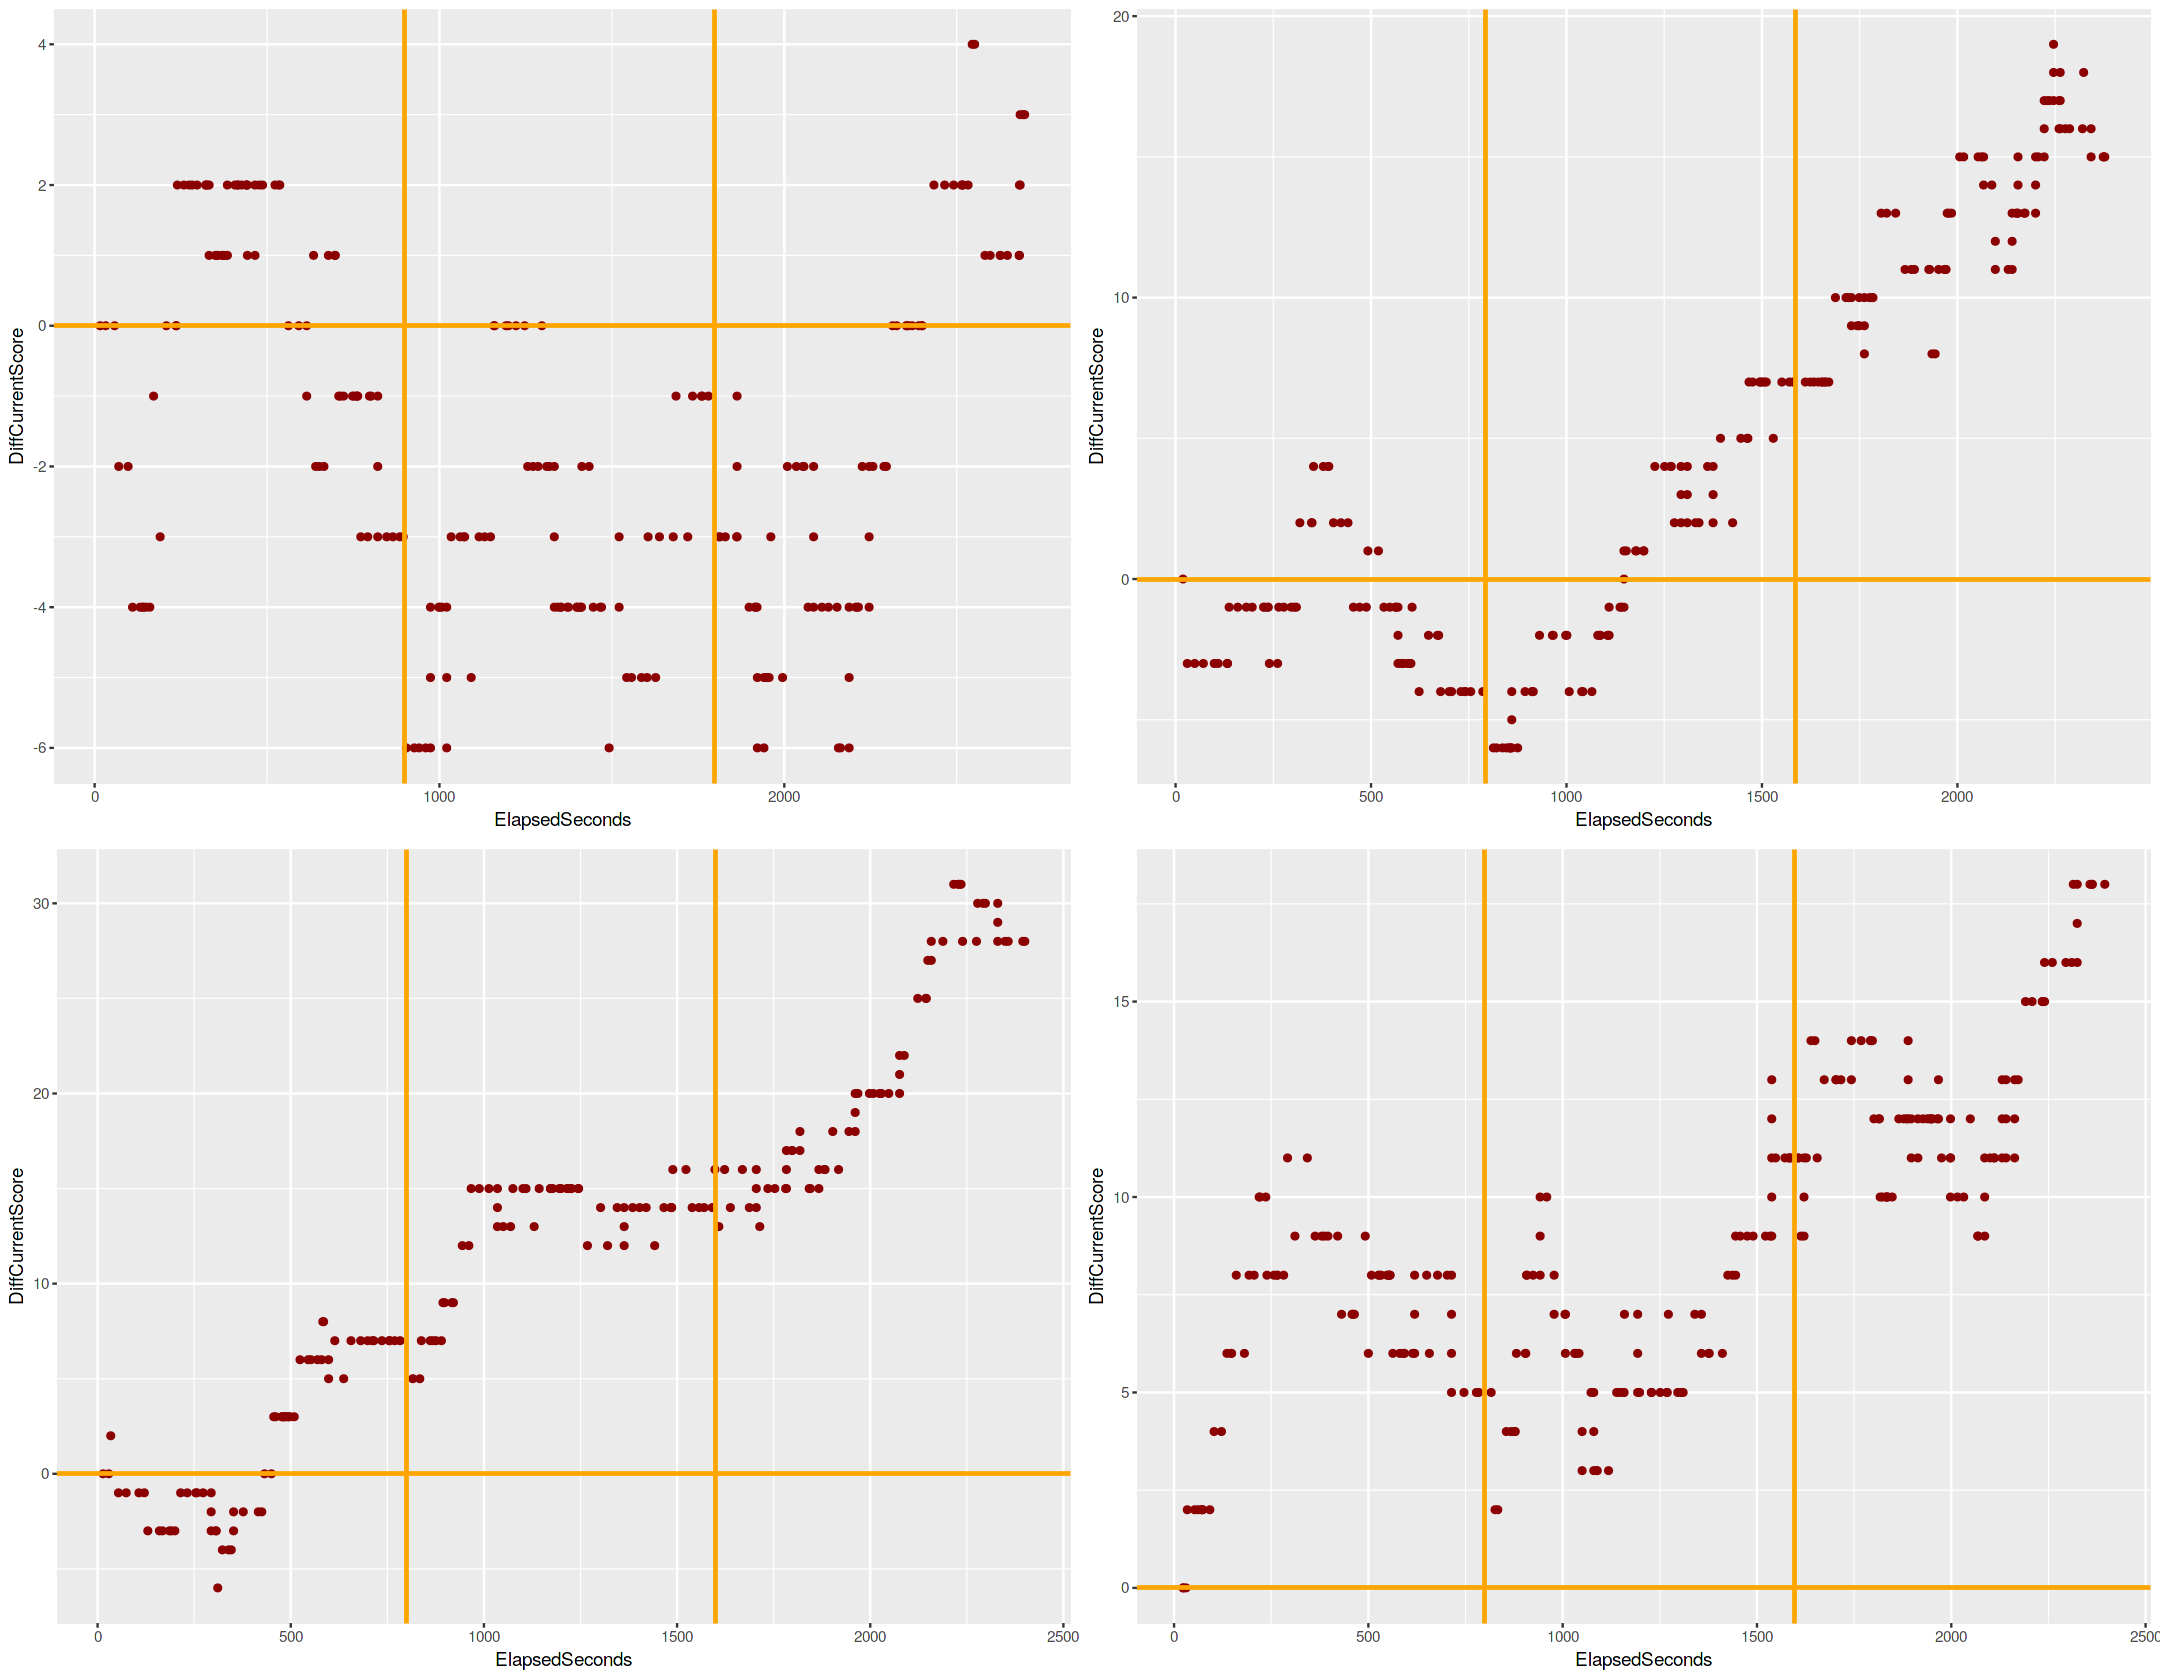

In [22]:
grid.newpage() 
pushViewport(viewport(layout = grid.layout(2, 2)))
k=0
while (k<4){
k=k+1
gameID<-result_SC$MatchID[k]
my_match=subset(game_SC, MatchID==gameID)
# ggplot(data = my_match, aes(x = ElapsedSeconds))+geom_line(aes(y = WCurrentScore), color = "darkred") + geom_line(aes(y = LCurrentScore), color="steelblue", linetype="twodash")
plot=ggplot(data = my_match, aes(x = ElapsedSeconds))+geom_point(aes(y = DiffCurrentScore), color = "darkred") +geom_hline(yintercept=0, color="orange", size=1) +geom_vline(xintercept=max(max(my_match$ElapsedSeconds))/3, color="orange", size=1)+ geom_vline(xintercept=2*max(max(my_match$ElapsedSeconds))/3, color="orange", size=1)
print(plot,vp = viewport(layout.pos.row = 1+(k-1)%/%2, layout.pos.col =1+(k+1)%%2))    
}


Finally, we gather for a given season the three metrics per play:


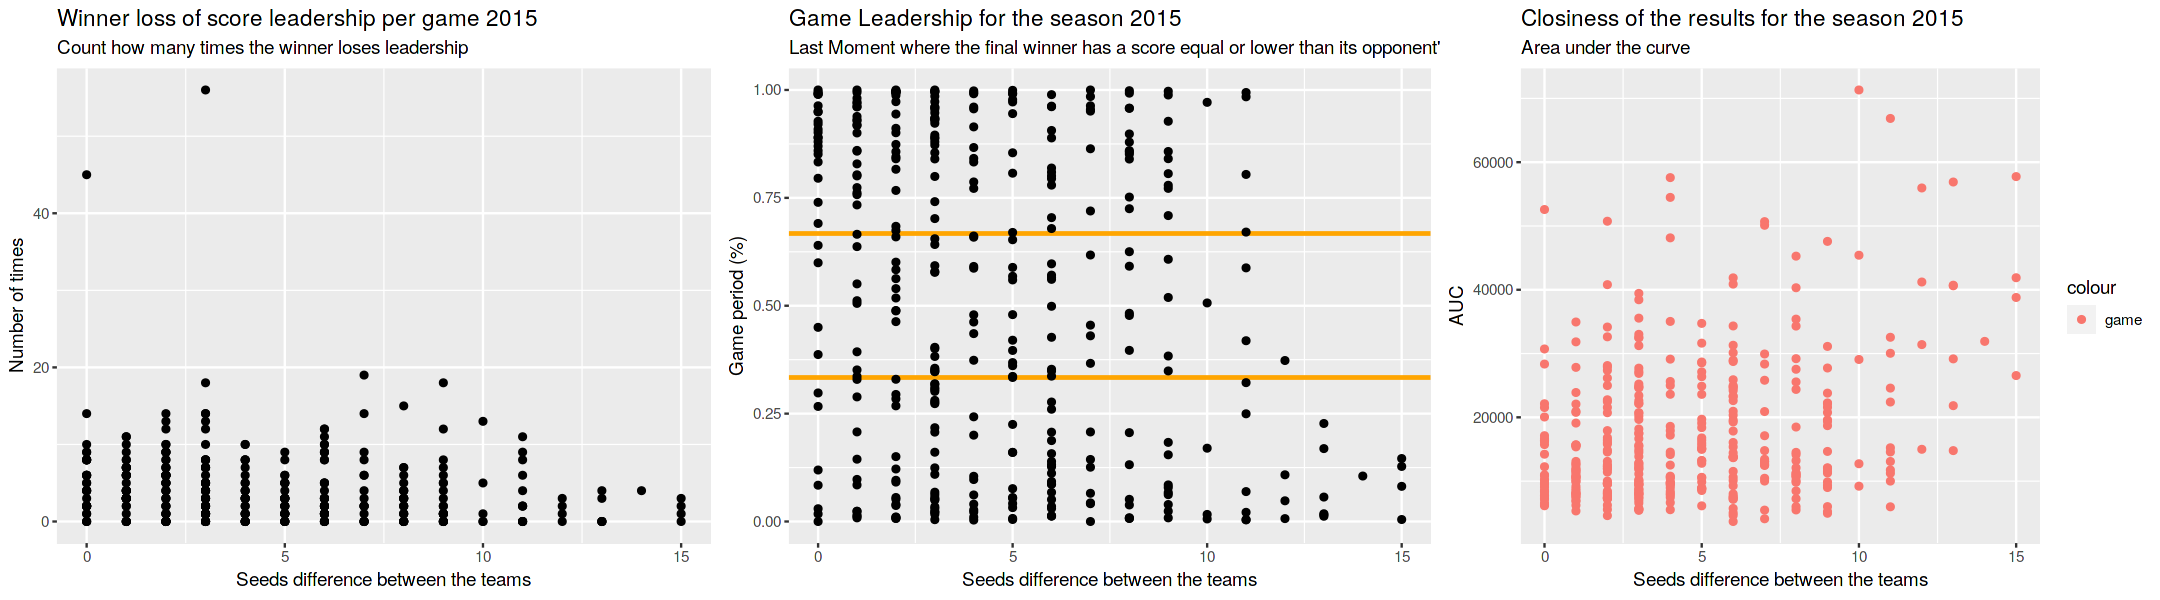

In [23]:
fig(18,5)
grid.newpage() 
pushViewport(viewport(layout = grid.layout(1, 3)))
s2015=result_SC
g1 <- ggplot(data=s2015, aes(s2015$DiffSeed, s2015$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2015")+geom_point()
print(g1,vp = viewport(layout.pos.row = 1, layout.pos.col =1))
g2 <- ggplot(data=s2015,aes(s2015$DiffSeed, s2015$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2015")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 1, layout.pos.col =2))
g3 <- ggplot(data=s2015, aes(s2015$DiffSeed, s2015$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2015")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 1, layout.pos.col =3))

Here we have presented the case of the 2015 season. Again, this routine can be easily scaled by incorporating it into a loop which iterates over all available seasons.

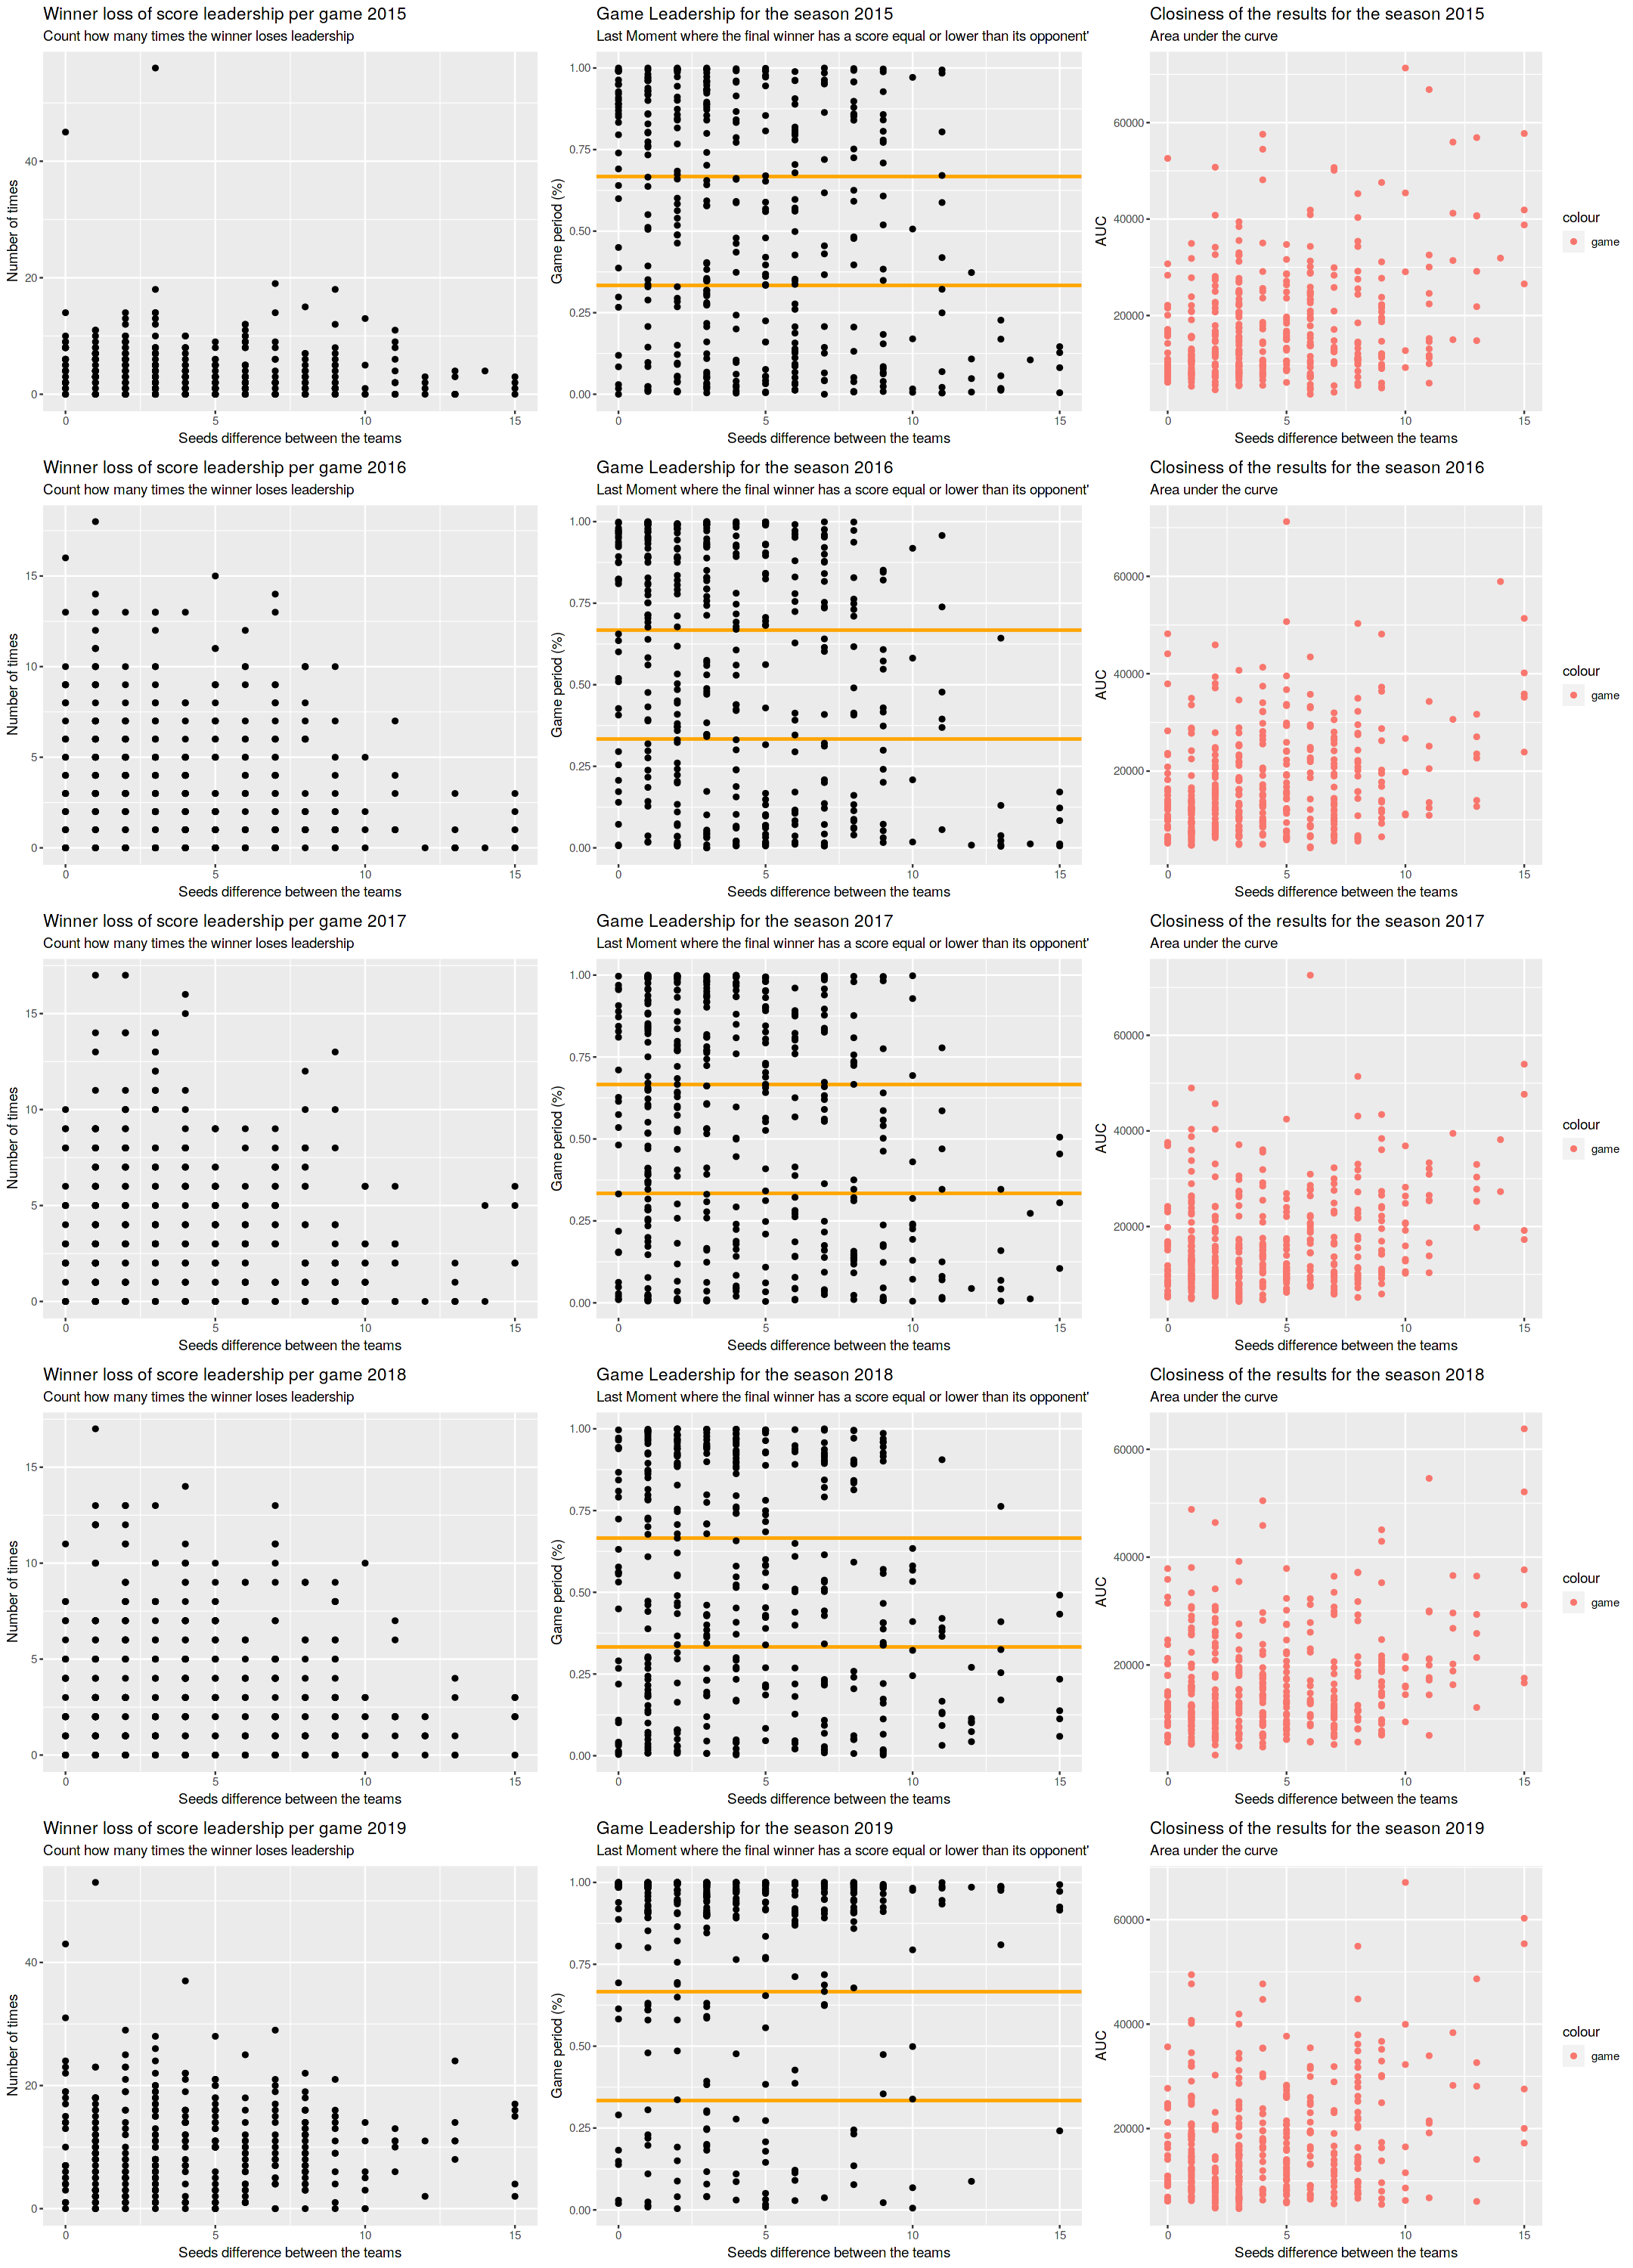

In [24]:
df_total = data.frame()
for (MEventsfile in c("../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2015.csv","../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2016.csv","../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2017.csv","../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2018.csv","../input/march-madness-analytics-2020/MPlayByPlay_Stage2/MEvents2019.csv")){
 
## Read the file
infomatch <- read.csv(MEventsfile,stringsAsFactors = FALSE)
SeasonConsidered=as.numeric(yextract(MEventsfile))

## Create recap_SC (SC= Season Considered)
## Table with all the games during the season. Contains the difference of Seeds for each match
seeds_SC=subset(seeds,Season==SeasonConsidered)
mysample <- infomatch %>% select("Season","WTeamID","LTeamID","DayNum")
mysample=unique(mysample)

recap_SC=merge(mysample,seeds_SC,by.x="WTeamID",by.y="TeamID")
recap_SC=select(recap_SC,"Season"="Season.x","WSeed"="Seed","WTeamID","LTeamID","DayNum")
recap_SC=merge(recap_SC,seeds_SC,by.x="LTeamID",by.y="TeamID")
recap_SC=select(recap_SC,"Season"="Season.x","DayNum","WTeamID","LTeamID","WSeed","LSeed"="Seed")
recap_SC$DiffSeed=abs(as.numeric(numextract(recap_SC$WSeed))-as.numeric(numextract(recap_SC$LSeed)))
recap_SC=recap_SC[order(recap_SC$WTeamID),]
recap_SC$MatchID <- seq.int(nrow(recap_SC))

## Create game_SC (SC= Season Considered)
## Table with all the history of the game during the season.  Associated with Match ID
buffer=select(infomatch,"Season","DayNum","WTeamID","LTeamID","WFinalScore","LFinalScore","WCurrentScore","LCurrentScore","ElapsedSeconds")
game_SC=merge(buffer,recap_SC,by=c("Season","DayNum","WTeamID","LTeamID"))
game_SC=select(game_SC,"MatchID","WTeamID","LTeamID","WFinalScore","LFinalScore","WCurrentScore","LCurrentScore","ElapsedSeconds")
game_SC=game_SC[order(game_SC$WTeamID,game_SC$MatchID,game_SC$ElapsedSeconds),]
game_SC["DiffCurrentScore"]=game_SC$WCurrentScore-game_SC$LCurrentScore
game_SC=unique(game_SC)

### Create result_SC.
### For each game, the area under the curve, the number of winner Switch and the time associated with the Last Switch
result_SC=data.frame(Season=SeasonConsidered,MatchID=recap_SC$MatchID,DiffSeed=recap_SC$DiffSeed)

for (gameID in result_SC$MatchID){
  my_match=subset(game_SC, MatchID==gameID)
  x <- my_match$ElapsedSeconds
  y <- abs(my_match$DiffCurrentScore)
  id <- order(x)
  AUC <- sum(diff(x[id])*rollmean(y[id],2))
  
  Sign=sign(my_match$DiffCurrentScore)
  Is_last=1
  count_lose_leadership=0

  for (id_Sign in 1:length(Sign)){
    if (Sign[id_Sign]<=0){
      Is_last=id_Sign
    }
    if (id_Sign<length(Sign) & Sign[id_Sign]>=0 & Sign[id_Sign+1]<0){
      count_lose_leadership=count_lose_leadership+1
    }
  }
  
  LastSwitch=my_match$ElapsedSeconds[Is_last]/my_match$ElapsedSeconds[length(my_match$ElapsedSeconds)] ## LastSwitch represents the last moment where the W team has the same OR a lower score than the L team
  Nb_Switch=count_lose_leadership ## Nb_Switch counts the number of time the W team lose the leadership , ie 0 -> Negative diff OR Positive diff -> Negatif diff
  result_SC$Nb_Switch[gameID]=Nb_Switch
  result_SC$AUC[gameID]=AUC
  result_SC$LastSwitch[gameID]=LastSwitch
  df <- data.frame(result_SC)
}

    
    df_total <- rbind(df_total,df)

} #final for

s2015=subset(df_total,df_total$Season==2015)
s2016=subset(df_total,df_total$Season==2016)
s2017=subset(df_total,df_total$Season==2017)
s2018=subset(df_total,df_total$Season==2018)
s2019=subset(df_total,df_total$Season==2019)

fig(18,25)
grid.newpage() 
pushViewport(viewport(layout = grid.layout(5, 3)))

g1 <- ggplot(data=s2015, aes(s2015$DiffSeed, s2015$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2015")+geom_point()
print(g1,vp = viewport(layout.pos.row = 1, layout.pos.col =1))
g2 <- ggplot(data=s2015,aes(s2015$DiffSeed, s2015$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2015")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 1, layout.pos.col =2))
g3 <- ggplot(data=s2015, aes(s2015$DiffSeed, s2015$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2015")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 1, layout.pos.col =3))

g1 <- ggplot(data=s2016, aes(s2016$DiffSeed, s2016$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2016")+geom_point()
print(g1,vp = viewport(layout.pos.row = 2, layout.pos.col =1))
g2 <- ggplot(data=s2016,aes(s2016$DiffSeed, s2016$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2016")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 2, layout.pos.col =2))
g3 <- ggplot(data=s2016, aes(s2016$DiffSeed, s2016$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2016")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 2, layout.pos.col =3))

g1 <- ggplot(data=s2017, aes(s2017$DiffSeed, s2017$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2017")+geom_point()
print(g1,vp = viewport(layout.pos.row = 3, layout.pos.col =1))
g2 <- ggplot(data=s2017,aes(s2017$DiffSeed, s2017$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2017")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 3, layout.pos.col =2))
g3 <- ggplot(data=s2017, aes(s2017$DiffSeed, s2017$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2017")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 3, layout.pos.col =3))

g1 <- ggplot(data=s2018, aes(s2018$DiffSeed, s2018$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2018")+geom_point()
print(g1,vp = viewport(layout.pos.row = 4, layout.pos.col =1))
g2 <- ggplot(data=s2018,aes(s2018$DiffSeed, s2018$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2018")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 4, layout.pos.col =2))
g3 <- ggplot(data=s2018, aes(s2018$DiffSeed, s2018$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2018")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 4, layout.pos.col =3))

g1 <- ggplot(data=s2019, aes(s2019$DiffSeed, s2019$Nb_Switch))
g1<-g1 +labs(subtitle="Count how many times the winner loses leadership", y="Number of times", x="Seeds difference between the teams",  title="Winner loss of score leadership per game 2019")+geom_point()
print(g1,vp = viewport(layout.pos.row = 5, layout.pos.col =1))
g2 <- ggplot(data=s2019,aes(s2019$DiffSeed, s2019$LastSwitch))
g2<-g2  +labs(subtitle="Last Moment where the final winner has a score equal or lower than its opponent's",  y="Game period (%)", x="Seeds difference between the teams",title="Game Leadership for the season 2019")+geom_hline(yintercept=1/3, color="orange", size=1)+ geom_hline(yintercept=2/3, color="orange", size=1)+geom_point()
print(g2,vp = viewport(layout.pos.row = 5, layout.pos.col =2))
g3 <- ggplot(data=s2019, aes(s2019$DiffSeed, s2019$AUC))
g3<-g3 + labs(subtitle="Area under the curve", y="AUC", x="Seeds difference between the teams", title="Closiness of the results for the season 2019")+geom_point(aes(color="game"))
print(g3,vp = viewport(layout.pos.row = 5, layout.pos.col =3))

### Step 2 : Presentation of the Results

#### First Metric: Nb_switch

Nb_switch is plotted against the seed difference between the team with each dot representing a game.

From an initial glance, we can divide the plot into two parts: under and over a seed difference of 9. For this first case, Nb_switch is relatively consistent with an approximate average of 12 for the 2016 season. In the second case, the Nb_switch barely attains an average of 5. In a closer loop, we can note that the high number of leadership switches are associated with a low seed difference.

We can also appreciate the overall increase of the number of leadership switch, regardless of the seed difference, as the season becomes more recent. This phenomenon is particularly visible when we considered the situation for the high seed difference situation. For example, in 2019, for the team seeded at 13 managed to take the leadership more than 10 times in 3 out of its four games, a performance three times higher than what could have observed in the past. Same trend is observed for the team seeded 15 in 2019.

#### Second Metric: Last_Switch

Last_Switch represents a proportion of the elapsed time and is plotted against the seed difference between the teams. The orange curves indicate the first, second, and third periods of play respectively. Once again, each dot represents a game.

As before, we see that we can divide the plot into two parts: under and over a seed difference of 9. For this first case, Last_switch spans over the possible range, concentrating round 0.8-1 for the five first seeds, regardless of the season. For the second case, Last_switch remains lower. For the 2015 season, all games with a seed difference higher than 12 have their Last_Switch under 0.25, meaning that after one quarter of the elapsed time, the winning team took the lead and retained it until the end. When we look at the most recent season, this trend changes to be more balanced: in 2019, most of the game involving high seed differences managed to keep their winning opponents at range until the last period.

A closer investigation shows that Last_switch spans over the possible range for a seed difference under 9. This indicates that even for a narrow seed difference, early leadership domination can be observed. For instance, when we look at the 2018 season, there is approximately the same proportion of games with close seeds with a Last_Switch that occurs either on the first, second, or third period. In other words, for this seed difference, the moment when the leading team gains its ultimate lead cannot be directly inferred from the seed difference.

#### Third Metric: AUC

AUC is plotted against the seed difference between the team. Continuing the trend established previously, each dot represents a game.

We see that a narrow score range is associated with a lower seed difference. Conversely, in a high difference seed situation, AUC become higher. The curves remain similar over the season illustrated the consistency of the seed selection over the time.

### Step 3 : Conclusion

This data exploration ultimately allowed us to get a better understanding of the influence of the seed difference on the closeness of a game.

As we have discussed, an intuitive assumption is that the closeness of a play is dependent only on the differences in seed of the playing teams. We wanted to assess the validity of this hypothesis with the three metrics analyzed above: the number of leadership switches, the last moment the winning team experience an equal or a lower score than its opponents, and the score closeness.

The correlation between the closeness and the seed difference has been confirmed for the large (>12) and small (<4) difference in seed. In the first case, the winning team tends to take the game leadership, quicker without considering lots of leadership change. Consequently, the range of the score becomes large. The second case, on contrary, shows that for a close game, a higher number a leadership switch, a narrow score range as well as long lasting competition is to be expected.

However, when studying the general case (seed difference between 5 and 11) this reasoning can be misleading. In these situations, the three metrics do not show a significant trend. No conclusions can then be drawn regarding the closeness when looking at games with a seed difference in this mid-range. On top of that, the trends become less distinct as we study the more recent NCAA season. In 2018, games with a seed of 8 experience the long-lasting competition with same number of leadership switches as for the game with teams with the same seeds.

Seed difference gives an indication, and only an indication, of the potential closeness of the game. In other words, if closeness is the main driver of the entertainment of a game, one may not solely rely of seed difference to define the associated madness. Tension, fear, and joy are more likely to be experienced in game associated with very low seed difference but not necessarily during a game involving team with a seed difference of 5 or 9. Our metrics then make us believe that the ultimate entertainment and madness can not be so simply predicted for a given type of game.